# Phase Circuit to CNOT+Rz+Rx gates
We have shown in the previous notebooks how to simplify and optimize Phase Circuits.
However, the multi-qubit phase gadgets in those examples are not suitable for direct execution on most quantum devices. Therefore, they are decomposed into CNOTs and single qubit gates that are allowed by the hardware.
In the previous notebooks, we have used a naive decomposing strategy for the phase gadgets. 

However, more intrigate strategies for decomposing sequences of phase gadgets are available. These have been implemented and we will see how they perform compared to the naive strategy.

## Some administrative setup

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: /Users/griendar/Documents/Github/pauliopt


General purpose imports:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np
# import qiskit

/var/folders/3q/vjbn2sl16r1g41lg5pk752khfzf5fm/T/ipykernel_16842/3958425799.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Some utility code to display HTML elements and images/figures side-by-side:

In [3]:
from io import BytesIO
from typing import Union
from IPython.display import Image, HTML # type: ignore
def figure_to_image(fig: plt.Figure, fmt: str = "png") -> Image:
    """ Converts a Matplotlib figure to a PNG IPython Image. """
    buffer = BytesIO()
    fig.savefig(buffer, format=fmt)
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    return Image(image_png, format=fmt, embed=True)
def side_by_side(*elements: Union[str, Image]) -> HTML:
    """
        Returns an HTML Div element with the given elements
        displayed side by side. Accepts raw HTML code or
        IPython Image objects.
    """
    html = f"<div style='display:flex; align-items: center;'>"
    for el in elements:
        if isinstance(el, str):
            html += el
        elif isinstance(el, Image):
            html += f"<img src='data:image/png;base64,{el._repr_png_()}'/>"
    html += f"</div>"
    return HTML(html)

## PhaseCircuit decomposition to CNOTs

For our running example, we use a 3x3 grid qubit topology:

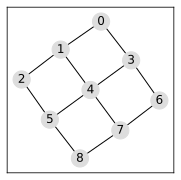

In [4]:
from pauliopt.topologies import Topology
topology = Topology.grid(3, 3)
topology.draw(figsize=(3, 3))

We construct a small random phase circuit on the same qubits:

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


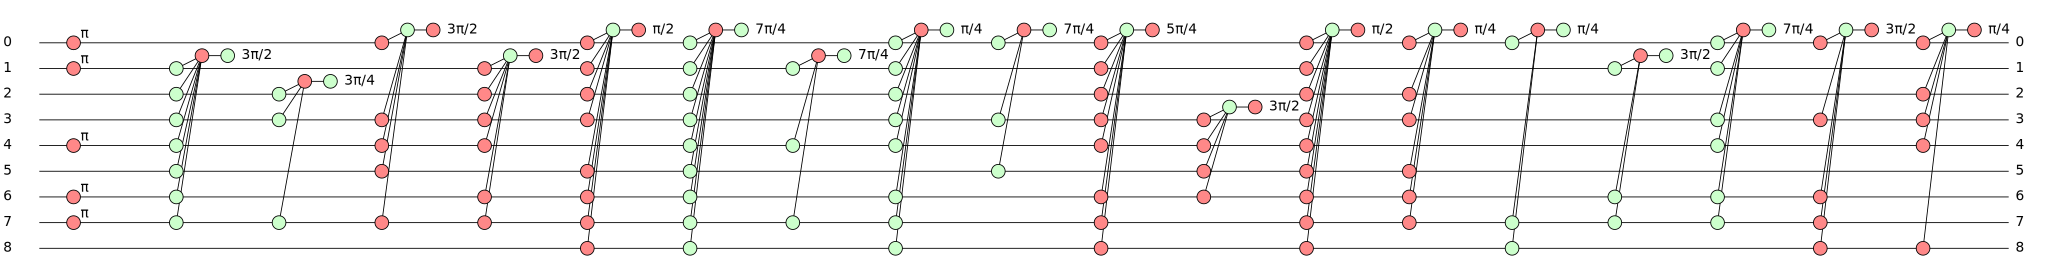

In [5]:
from pauliopt.phase import PhaseCircuit, CXCircuit
import pyzx
orig_circuit = PhaseCircuit.random(topology.num_qubits, 20, min_legs=3, rng_seed=0).simplified()
orig_circuit

In [6]:
def draw_qiskit_circuit(phasecircuit, topology, method, reallocate=False):
    circuit = phasecircuit.to_qiskit(topology, method, reallocate=reallocate)
    print(circuit.count_ops())
    if reallocate:
        print(circuit.metadata)
    display(circuit.draw())
    return circuit

def circuit_to_pyzx(circuit):
    diagram = pyzx.Circuit.from_qasm(circuit.qasm())
    display(pyzx.draw(diagram))
    return diagram


We then decompose the circuit into CNOTs and single qubit rotations

Count the number of operators for each of the circuits

In [7]:
orig_circuit_naive = draw_qiskit_circuit(orig_circuit, topology, "naive")
orig_circuit_diagram = circuit_to_pyzx(orig_circuit_naive)

OrderedDict([('cx', 206), ('rx', 14), ('rz', 9)])


┌───────┐                                                              »
q_0: ┤ Rx(π) ├──────────────────────────────────────────────────────────────»
     ├───────┤                    ┌───┐┌───┐┌──────────┐┌───┐┌───┐          »
q_1: ┤ Rx(π) ├────────────────────┤ X ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──────────»
     └───────┘┌───┐               └─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘┌───┐     »
q_2: ─────────┤ X ├─────────────────┼────■────────────────■────┼──┤ X ├─────»
              └─┬─┘┌───┐            │                          │  └─┬─┘     »
q_3: ───────────┼──┤ X ├──■─────────┼──────────────────────────┼────┼───────»
     ┌───────┐  │  └─┬─┘┌─┴─┐┌───┐  │                          │    │  ┌───┐»
q_4: ┤ Rx(π) ├──┼────┼──┤ X ├┤ X ├──■──────────────────────────■────┼──┤ X ├»
     └───────┘  │    │  └───┘└─┬─┘                                  │  └─┬─┘»
q_5: ───────────■────┼─────────┼────────────────────────────────────■────┼──»
     ┌───────┐       │         │                                         │  »
q_6: ┤ Rx(π) ├───────■─────────┼─────────────────────────────────────────┼──»
     ├───────┤                 │                                         │  »
q_7: ┤ Rx(π) ├─────────────────■─────────────────────────────────────────■──»
     └───────┘                                                              »
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                   ┌───┐┌───┐                                »
«q_0: ───────────────────────────■──┤ X ├┤ X ├──■──────────────────────────■──»
«                                │  └─┬─┘└─┬─┘┌─┴─┐                      ┌─┴─┐»
«q_1: ───────────────────────────┼────┼────■──┤ X ├──■────────────────■──┤ X ├»
«                                │    │       └───┘┌─┴─┐┌──────────┐┌─┴─┐└───┘»
«q_2: ───────────────────────────┼────┼────────────┤ X ├┤ Rz(3π/4) ├┤ X ├─────»
«          ┌───┐          ┌───┐┌─┴─┐  │            └───┘└──────────┘└───┘     »
«q_3: ──■──┤ X ├──────────┤ X ├┤ X ├──■───────────────────────────────────────»
«     ┌─┴─┐└─┬─┘     ┌───┐└─┬─┘└───┘                                          »
«q_4: ┤ X ├──┼────■──┤ X ├──■─────────────────────────────────────────────────»
«     └───┘  │    │  └─┬─┘                                                    »
«q_5: ───────┼────┼────┼──────────────────────────────────────────────────────»
«            │    │    │                                                      »
«q_6: ───────■────┼────┼──────────────────────────────────────────────────────»
«               ┌─┴─┐  │                                                      »
«q_7: ──────────┤ X ├──■──────────────────────────────────────────────────────»
«               └───┘                                                         »
«q_8: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«     ┌───┐┌───┐                                        ┌──────────┐          »
«q_0: ┤ X ├┤ X ├──■──────────────────────────────────■──┤ Rx(3π/2) ├──■───────»
«     └─┬─┘└─┬─┘  │                                  │  └──────────┘  │       »
«q_1: ──■────┼────┼──────────────────────────────────┼────────────────┼───────»
«            │    │                                  │                │       »
«q_2: ───────┼────┼──────────────────────────────────┼────────────────┼───────»
«            │  ┌─┴─┐┌───┐                         ┌─┴─┐            ┌─┴─┐     »
«q_3: ───────■──┤ X ├┤ X ├──────────────────────■──┤ X ├────────────┤ X ├──■──»
«               └───┘└─┬─┘┌───┐               ┌─┴─┐└───┘            └───┘┌─┴─┐»
«q_4: ─────────────────■──┤ X ├──■────■────■──┤ X ├──────────────────────┤ X ├»
«                         └─┬─┘  │    │  ┌─┴─┐└───┘                      └───┘»
«q_5: ──────────────────────┼────┼────┼──┤ X ├────────────────────────────────»
«                           │    │    │  └─

None

In [8]:
def check_equivalence(diagram):
    return orig_circuit_diagram.verify_equality(diagram)

def check_equivalence_circuit(circuit):
    return check_equivalence(circuit_to_pyzx(circuit))

orig_circuit_parity = draw_qiskit_circuit(orig_circuit, topology, "paritysynth")
print("The new circuit is equal:", check_equivalence_circuit(orig_circuit_parity))

OrderedDict([('cx', 154), ('rx', 14), ('rz', 9)])


┌───────┐                                          ┌───┐               »
q_0: ┤ Rx(π) ├──────────────────────────────────────────┤ X ├───────────────»
     ├───────┤     ┌───┐                                └─┬─┘               »
q_1: ┤ Rx(π) ├─────┤ X ├─────────────────■───────■────────■─────────────────»
     └───────┘┌───┐└─┬─┘                 │     ┌─┴─┐                        »
q_2: ─────────┤ X ├──■─────────■─────────┼─────┤ X ├────────────────────────»
              └─┬─┘┌───┐       │         │     └───┘    ┌───┐          ┌───┐»
q_3: ───────────┼──┤ X ├──■────┼─────────┼──────────────┤ X ├──────────┤ X ├»
     ┌───────┐  │  └─┬─┘┌─┴─┐  │  ┌───┐┌─┴─┐┌──────────┐└─┬─┘┌───┐┌───┐└─┬─┘»
q_4: ┤ Rx(π) ├──┼────┼──┤ X ├──┼──┤ X ├┤ X ├┤ Rz(3π/2) ├──■──┤ X ├┤ X ├──■──»
     └───────┘  │    │  └───┘┌─┴─┐└─┬─┘└───┘└──────────┘     └─┬─┘└─┬─┘     »
q_5: ───────────■────┼───────┤ X ├──┼──────────────────────────┼────■───────»
     ┌───────┐       │       └───┘  │                          │            »
q_6: ┤ Rx(π) ├───────■──────────────┼──────────────────────────┼────────────»
     ├───────┤                      │                          │            »
q_7: ┤ Rx(π) ├──────────────────────■──────────────────────────■────────────»
     └───────┘                                                              »
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                              ┌───┐                                         »
«q_0: ───────■─────────────────┤ X ├─────────────────────────────────────────»
«            │     ┌───┐       └─┬─┘                                         »
«q_1: ───────┼─────┤ X ├─────────┼───────────────────────────────────────────»
«            │     └─┬─┘         │                               ┌──────────┐»
«q_2: ───────┼───────┼───────────┼────────────────────────────■──┤ Rx(3π/2) ├»
«          ┌─┴─┐     │           │                            │  └──────────┘»
«q_3: ──■──┤ X ├─────┼───────────■────────────────────────────┼───────■──────»
«       │  └───┘     │      ┌──────────┐┌───┐          ┌───┐  │     ┌─┴─┐    »
«q_4: ──┼────■───────■──────┤ Rx(3π/2) ├┤ X ├───────■──┤ X ├──┼─────┤ X ├────»
«       │    │              └──────────┘└─┬─┘       │  └─┬─┘┌─┴─┐   └───┘    »
«q_5: ──┼────┼────────────────────────────┼─────────┼────■──┤ X ├────────────»
«     ┌─┴─┐  │  ┌──────────┐              │  ┌───┐  │  ┌───┐└───┘            »
«q_6: ┤ X ├──┼──┤ Rz(3π/4) ├──────────────┼──┤ X ├──┼──┤ X ├─────────────────»
«     └───┘┌─┴─┐└──────────┘              │  └─┬─┘┌─┴─┐└─┬─┘                 »
«q_7: ─────┤ X ├──────────────────────────■────■──┤ X ├──■───────────────────»
«          └───┘                                  └───┘                      »
«q_8: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«                                                                ┌───┐     »
«q_0: ────────────■──────────────────────────────────────────────┤ X ├──■──»
«          ┌───┐┌─┴─┐┌──────────┐     ┌───┐┌──────────┐     ┌───┐└─┬─┘  │  »
«q_1: ─────┤ X ├┤ X ├┤ Rz(7π/4) ├─────┤ X ├┤ Rz(7π/4) ├──■──┤ X ├──■────┼──»
«          └─┬─┘└───┘├─────────┬┘     └─┬─┘└──────────┘┌─┴─┐└─┬─┘       │  »
«q_2: ──■────■────■──┤ Rx(π/2) ├────────┼──────────────┤ X ├──■─────────┼──»
«       │         │  └─────────┘        │              └───┘          ┌─┴─┐»
«q_3: ──┼─────────┼─────────────────────┼─────────────────────────────┤ X ├»
«       │         │              ┌───┐  │                             └───┘»
«q_4: ──┼─────────┼──────────────┤ X ├──■──────────────────────────────────»
«     ┌─┴─┐     ┌─┴─┐   ┌───┐    └─┬─┘┌───┐                                »
«q_5: ┤ X ├──■──┤ X ├───┤ X ├──────■──┤ X ├────────────────────────────────»
«     └───┘  │  └───┘   └─┬─┘         └─┬─┘                                »
«q_6: ───────┼───────

None

The new circuit is equal: True


In [9]:
orig_circuit_gray = draw_qiskit_circuit(orig_circuit, topology, "steiner-graysynth")
print("The new circuit is equal:", check_equivalence_circuit(orig_circuit_gray))

OrderedDict([('cx', 169), ('rx', 14), ('rz', 9)])


┌───────┐                    ┌───┐                                     »
q_0: ┤ Rx(π) ├─────────────────■──┤ X ├─────────────────────────────────────»
     ├───────┤               ┌─┴─┐└─┬─┘                      ┌───┐          »
q_1: ┤ Rx(π) ├────────────■──┤ X ├──■────────────────────────┤ X ├──────────»
     └───────┘┌───┐     ┌─┴─┐└───┘             ┌───┐         └─┬─┘          »
q_2: ─────────┤ X ├──■──┤ X ├──────────────────┤ X ├──────■────■────────────»
              └─┬─┘  │  ├───┤                  └─┬─┘      │                 »
q_3: ───────────┼────┼──┤ X ├──■─────────────────┼────────┼────■────────────»
     ┌───────┐  │    │  └─┬─┘┌─┴─┐┌───┐          │        │  ┌─┴─┐┌───┐     »
q_4: ┤ Rx(π) ├──┼────┼────■──┤ X ├┤ X ├──■───────┼────────┼──┤ X ├┤ X ├──■──»
     └───────┘  │  ┌─┴─┐     └───┘└─┬─┘  │       │      ┌─┴─┐└───┘└─┬─┘  │  »
q_5: ───────────■──┤ X ├────────────■────┼───────■──────┤ X ├───────■────┼──»
     ┌───────┐     └───┘                 │              └───┘            │  »
q_6: ┤ Rx(π) ├───────────────────────────┼───────────────────────────────┼──»
     ├───────┤                         ┌─┴─┐┌──────────┐               ┌─┴─┐»
q_7: ┤ Rx(π) ├─────────────────────────┤ X ├┤ Rz(3π/4) ├───────────────┤ X ├»
     └───────┘                         └───┘└──────────┘               └───┘»
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                     ┌───┐                          ┌───┐     »
«q_0: ────────────────────────■────■──┤ X ├──────────────────────────┤ X ├──■──»
«                             │  ┌─┴─┐└─┬─┘┌───┐     ┌───┐           └─┬─┘┌─┴─┐»
«q_1: ────────────────────────┼──┤ X ├──■──┤ X ├─────┤ X ├─────■───────■──┤ X ├»
«     ┌───┐                   │  └───┘     └─┬─┘┌───┐└─┬─┘   ┌─┴─┐        └───┘»
«q_2: ┤ X ├───────────────────┼──────────────■──┤ X ├──■─────┤ X ├─────■───────»
«     └─┬─┘                 ┌─┴─┐               └─┬─┘        └───┘     │       »
«q_3: ──┼────────────────■──┤ X ├──■──────────────┼────────────────────┼───────»
«       │                │  └───┘  │              │                    │       »
«q_4: ──┼────────────────┼─────────┼──────────────┼────────────────────┼───────»
«       │  ┌──────────┐  │         │              │  ┌───┐           ┌─┴─┐┌───┐»
«q_5: ──■──┤ Rx(3π/2) ├──┼─────────┼──────────────■──┤ X ├───────────┤ X ├┤ X ├»
«          └──────────┘┌─┴─┐     ┌─┴─┐               └─┬─┘           └───┘└─┬─┘»
«q_6: ──■──────────────┤ X ├─────┤ X ├─────────────────┼────────────────────┼──»
«     ┌─┴─┐┌──────────┐└───┘     └───┘                 │                    │  »
«q_7: ┤ X ├┤ Rz(3π/2) ├────────────────────────────────┼────────────────────┼──»
«     └───┘└──────────┘                                │  ┌─────────┐       │  »
«q_8: ─────────────────────────────────────────────────■──┤ Rx(π/2) ├───────■──»
«                                                         └─────────┘          »
«     ┌───┐                                                                   »
«q_0: ┤ X ├───────────────────────────────────────────────────────────────────»
«     └─┬─┘                                                                   »
«q_1: ──┼────────────────────────────────────■────────────────────────────────»
«       │                                    │                   ┌───┐        »
«q_2: ──┼────────────────────────────────────┼───────────────────┤ X ├─────■──»
«       │  ┌──────────┐                      │                   └─┬─┘     │  »
«q_3: ──■──┤ Rx(3π/2) ├─────■────────────────┼─────────────────────┼───────┼──»
«          └──────────┘   ┌─┴─┐            ┌─┴─┐                   │       │  »
«q_4: ────────────────────┤ X ├──────■─────┤ X ├──────■────────────┼───────┼──»
«                         └───┘    ┌─┴─┐┌──┴───┴───┐┌─┴─┐          │     ┌─┴─┐»
«q_5: ──■──────────────────────────┤ X ├┤ Rz(7π/4) ├┤ X ├──■───────■─────┤ X ├»
«       │               

None

The new circuit is equal: True


In [10]:
draw_qiskit_circuit(orig_circuit, topology, "paritysynth", True)

OrderedDict([('cx', 122), ('rx', 14), ('rz', 9)])
{'final_layout': [4, 0, 8, 5, 7, 1, 2, 3, 6]}


┌───────┐                                          ┌───┐               »
q_0: ┤ Rx(π) ├──────────────────────────────────────────┤ X ├───────────────»
     ├───────┤     ┌───┐                                └─┬─┘               »
q_1: ┤ Rx(π) ├─────┤ X ├─────────────────■───────■────────■─────────────────»
     └───────┘┌───┐└─┬─┘                 │     ┌─┴─┐                        »
q_2: ─────────┤ X ├──■─────────■─────────┼─────┤ X ├────────────────────────»
              └─┬─┘┌───┐       │         │     └───┘    ┌───┐          ┌───┐»
q_3: ───────────┼──┤ X ├──■────┼─────────┼──────────────┤ X ├──────────┤ X ├»
     ┌───────┐  │  └─┬─┘┌─┴─┐  │  ┌───┐┌─┴─┐┌──────────┐└─┬─┘┌───┐┌───┐└─┬─┘»
q_4: ┤ Rx(π) ├──┼────┼──┤ X ├──┼──┤ X ├┤ X ├┤ Rz(3π/2) ├──■──┤ X ├┤ X ├──■──»
     └───────┘  │    │  └───┘┌─┴─┐└─┬─┘└───┘└──────────┘     └─┬─┘└─┬─┘     »
q_5: ───────────■────┼───────┤ X ├──┼──────────────────────────┼────■───────»
     ┌───────┐       │       └───┘  │                          │            »
q_6: ┤ Rx(π) ├───────■──────────────┼──────────────────────────┼────────────»
     ├───────┤                      │                          │            »
q_7: ┤ Rx(π) ├──────────────────────■──────────────────────────■────────────»
     └───────┘                                                              »
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                              ┌───┐                                         »
«q_0: ───────■─────────────────┤ X ├─────────────────────────────────────────»
«            │     ┌───┐       └─┬─┘                                         »
«q_1: ───────┼─────┤ X ├─────────┼───────────────────────────────────────────»
«            │     └─┬─┘         │                               ┌──────────┐»
«q_2: ───────┼───────┼───────────┼────────────────────────────■──┤ Rx(3π/2) ├»
«          ┌─┴─┐     │           │                            │  └──────────┘»
«q_3: ──■──┤ X ├─────┼───────────■────────────────────────────┼───────■──────»
«       │  └───┘     │      ┌──────────┐┌───┐          ┌───┐  │     ┌─┴─┐    »
«q_4: ──┼────■───────■──────┤ Rx(3π/2) ├┤ X ├───────■──┤ X ├──┼─────┤ X ├────»
«       │    │              └──────────┘└─┬─┘       │  └─┬─┘┌─┴─┐   └───┘    »
«q_5: ──┼────┼────────────────────────────┼─────────┼────■──┤ X ├────────────»
«     ┌─┴─┐  │  ┌──────────┐              │  ┌───┐  │  ┌───┐└───┘            »
«q_6: ┤ X ├──┼──┤ Rz(3π/4) ├──────────────┼──┤ X ├──┼──┤ X ├─────────────────»
«     └───┘┌─┴─┐└──────────┘              │  └─┬─┘┌─┴─┐└─┬─┘                 »
«q_7: ─────┤ X ├──────────────────────────■────■──┤ X ├──■───────────────────»
«          └───┘                                  └───┘                      »
«q_8: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«                                                                ┌───┐     »
«q_0: ────────────■──────────────────────────────────────────────┤ X ├──■──»
«          ┌───┐┌─┴─┐┌──────────┐     ┌───┐┌──────────┐     ┌───┐└─┬─┘  │  »
«q_1: ─────┤ X ├┤ X ├┤ Rz(7π/4) ├─────┤ X ├┤ Rz(7π/4) ├──■──┤ X ├──■────┼──»
«          └─┬─┘└───┘├─────────┬┘     └─┬─┘└──────────┘┌─┴─┐└─┬─┘       │  »
«q_2: ──■────■────■──┤ Rx(π/2) ├────────┼──────────────┤ X ├──■─────────┼──»
«       │         │  └─────────┘        │              └───┘          ┌─┴─┐»
«q_3: ──┼─────────┼─────────────────────┼─────────────────────────────┤ X ├»
«       │         │              ┌───┐  │                             └───┘»
«q_4: ──┼─────────┼──────────────┤ X ├──■──────────────────────────────────»
«     ┌─┴─┐     ┌─┴─┐   ┌───┐    └─┬─┘┌───┐                                »
«q_5: ┤ X ├──■──┤ X ├───┤ X ├──────■──┤ X ├────────────────────────────────»
«     └───┘  │  └───┘   └─┬─┘         └─┬─┘                                »
«q_6: ───────┼───────

In [11]:
draw_qiskit_circuit(orig_circuit, topology, "steiner-graysynth", True)

OrderedDict([('cx', 151), ('rx', 14), ('rz', 9)])
{'final_layout': [3, 1, 2, 5, 8, 7, 6, 4, 0]}


┌───────┐                    ┌───┐                                     »
q_0: ┤ Rx(π) ├─────────────────■──┤ X ├─────────────────────────────────────»
     ├───────┤               ┌─┴─┐└─┬─┘                      ┌───┐          »
q_1: ┤ Rx(π) ├────────────■──┤ X ├──■────────────────────────┤ X ├──────────»
     └───────┘┌───┐     ┌─┴─┐└───┘             ┌───┐         └─┬─┘          »
q_2: ─────────┤ X ├──■──┤ X ├──────────────────┤ X ├──────■────■────────────»
              └─┬─┘  │  ├───┤                  └─┬─┘      │                 »
q_3: ───────────┼────┼──┤ X ├──■─────────────────┼────────┼────■────────────»
     ┌───────┐  │    │  └─┬─┘┌─┴─┐┌───┐          │        │  ┌─┴─┐┌───┐     »
q_4: ┤ Rx(π) ├──┼────┼────■──┤ X ├┤ X ├──■───────┼────────┼──┤ X ├┤ X ├──■──»
     └───────┘  │  ┌─┴─┐     └───┘└─┬─┘  │       │      ┌─┴─┐└───┘└─┬─┘  │  »
q_5: ───────────■──┤ X ├────────────■────┼───────■──────┤ X ├───────■────┼──»
     ┌───────┐     └───┘                 │              └───┘            │  »
q_6: ┤ Rx(π) ├───────────────────────────┼───────────────────────────────┼──»
     ├───────┤                         ┌─┴─┐┌──────────┐               ┌─┴─┐»
q_7: ┤ Rx(π) ├─────────────────────────┤ X ├┤ Rz(3π/4) ├───────────────┤ X ├»
     └───────┘                         └───┘└──────────┘               └───┘»
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                     ┌───┐                          ┌───┐     »
«q_0: ────────────────────────■────■──┤ X ├──────────────────────────┤ X ├──■──»
«                             │  ┌─┴─┐└─┬─┘┌───┐     ┌───┐           └─┬─┘┌─┴─┐»
«q_1: ────────────────────────┼──┤ X ├──■──┤ X ├─────┤ X ├─────■───────■──┤ X ├»
«     ┌───┐                   │  └───┘     └─┬─┘┌───┐└─┬─┘   ┌─┴─┐        └───┘»
«q_2: ┤ X ├───────────────────┼──────────────■──┤ X ├──■─────┤ X ├─────■───────»
«     └─┬─┘                 ┌─┴─┐               └─┬─┘        └───┘     │       »
«q_3: ──┼────────────────■──┤ X ├──■──────────────┼────────────────────┼───────»
«       │                │  └───┘  │              │                    │       »
«q_4: ──┼────────────────┼─────────┼──────────────┼────────────────────┼───────»
«       │  ┌──────────┐  │         │              │  ┌───┐           ┌─┴─┐┌───┐»
«q_5: ──■──┤ Rx(3π/2) ├──┼─────────┼──────────────■──┤ X ├───────────┤ X ├┤ X ├»
«          └──────────┘┌─┴─┐     ┌─┴─┐               └─┬─┘           └───┘└─┬─┘»
«q_6: ──■──────────────┤ X ├─────┤ X ├─────────────────┼────────────────────┼──»
«     ┌─┴─┐┌──────────┐└───┘     └───┘                 │                    │  »
«q_7: ┤ X ├┤ Rz(3π/2) ├────────────────────────────────┼────────────────────┼──»
«     └───┘└──────────┘                                │  ┌─────────┐       │  »
«q_8: ─────────────────────────────────────────────────■──┤ Rx(π/2) ├───────■──»
«                                                         └─────────┘          »
«     ┌───┐                                                                   »
«q_0: ┤ X ├───────────────────────────────────────────────────────────────────»
«     └─┬─┘                                                                   »
«q_1: ──┼────────────────────────────────────■────────────────────────────────»
«       │                                    │                   ┌───┐        »
«q_2: ──┼────────────────────────────────────┼───────────────────┤ X ├─────■──»
«       │  ┌──────────┐                      │                   └─┬─┘     │  »
«q_3: ──■──┤ Rx(3π/2) ├─────■────────────────┼─────────────────────┼───────┼──»
«          └──────────┘   ┌─┴─┐            ┌─┴─┐                   │       │  »
«q_4: ────────────────────┤ X ├──────■─────┤ X ├──────■────────────┼───────┼──»
«                         └───┘    ┌─┴─┐┌──┴───┴───┐┌─┴─┐          │     ┌─┴─┐»
«q_5: ──■──────────────────────────┤ X ├┤ Rz(7π/4) ├┤ X ├──■───────■─────┤ X ├»
«       │               

# Using this decomposition method together with the annealing optimization

In [12]:
from pauliopt.phase import OptimizedPhaseCircuit
from math import log10, ceil
def log_iter(it, prev_cost, new_cost, accepted, flip, t, num_iters):
    if new_cost < prev_cost: 
        print(f"Iter #{it:>0{ceil(log10(num_iters-1))}}, new cost: {new_cost}")
loggers = {
    "log_start": lambda cost, num_iters: print(f"Init cost: {cost}"),
    "log_iter": log_iter,
    "log_end": lambda cost, num_iters: print(f"Final cost: {cost}"),
}

In [13]:
def opt_to_qiskit(opt, method, reallocate=False):
    qiskit_circuit = opt.to_qiskit(method, reallocate=reallocate)
    display(qiskit_circuit.draw())
    print(qiskit_circuit.count_ops())
    print("cx" in qiskit_circuit.count_ops())
    if reallocate:
        print(qiskit_circuit.metadata)
    else:
        print("The new circuit is equal:", check_equivalence_circuit(qiskit_circuit))
    
def run_annealer(circuit, cx_block, method, reallocate=False):
    opt = OptimizedPhaseCircuit(orig_circuit, topology, cx_block=cx_block, rng_seed=0, method=method)
    opt.anneal(100, schedule=("geometric", 1, 1e-5), loggers=loggers, method=method, reallocate=reallocate)

    display(opt.phase_block.to_svg(scale=0.8))
    display(opt.cx_block.draw(figsize=(3, 3)))
    opt_to_qiskit(opt, method)
    return opt

Init cost: 206
Iter #00, new cost: 202
Iter #03, new cost: 196
Iter #04, new cost: 190
Iter #16, new cost: 182
Iter #18, new cost: 180
Final cost: 180


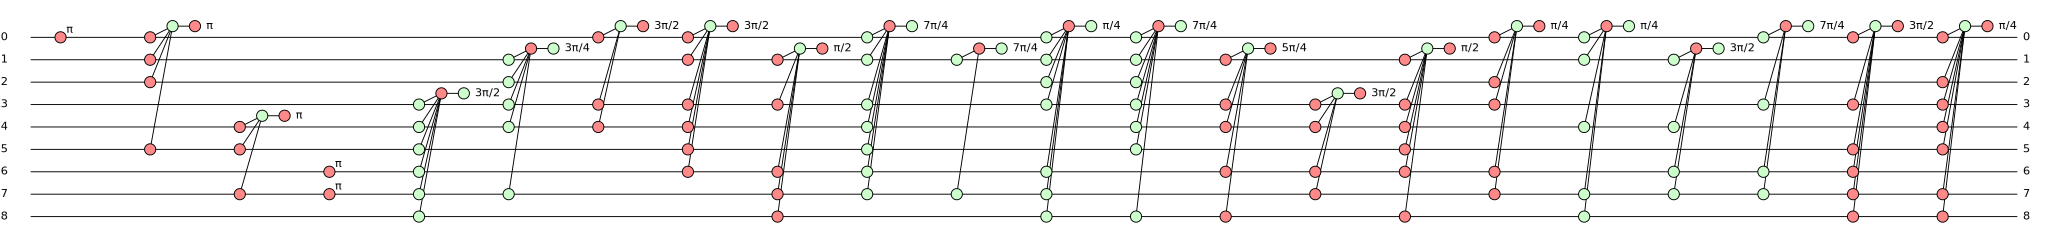

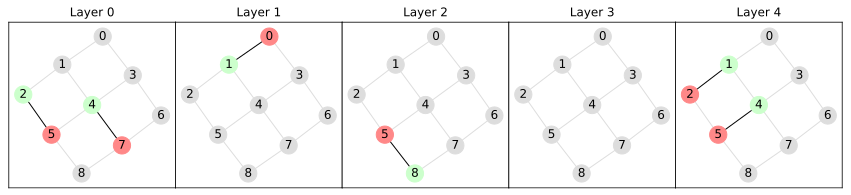

None

┌───┐┌───────┐                              ┌───────┐          »
q_0: ─────────┤ X ├┤ Rx(π) ├───────────────────────────■──┤ Rx(π) ├──■───────»
              └─┬─┘└───────┘                         ┌─┴─┐└───────┘┌─┴─┐     »
q_1: ────■──────■─────────────────────────────────■──┤ X ├─────────┤ X ├──■──»
       ┌─┴─┐                                    ┌─┴─┐└───┘         └───┘┌─┴─┐»
q_2: ──┤ X ├───────────────────────■─────────■──┤ X ├───────────────────┤ X ├»
       └───┘                ┌───┐  │         │  └───┘                   └───┘»
q_3: ───────────────────────┤ X ├──┼─────────┼───────────────────────────────»
                            └─┬─┘  │         │                               »
q_4: ────■─────────────■──────┼────┼────■────┼───────────────────────────────»
       ┌─┴─┐  ┌───┐    │      │  ┌─┴─┐  │  ┌─┴─┐                             »
q_5: ──┤ X ├──┤ X ├────┼──────┼──┤ X ├──┼──┤ X ├─────────────────────────────»
     ┌─┴───┴─┐└─┬─┘    │      │  └───┘  │  └───┘                             »
q_6: ┤ Rx(π) ├──┼──────┼──────■─────────┼────────────────────────────────────»
     └───────┘  │    ┌─┴─┐            ┌─┴─┐                                  »
q_7: ───────────┼────┤ X ├────────────┤ X ├──────────────────────────────────»
                │    └───┘            └───┘                                  »
q_8: ───────────■────────────────────────────────────────────────────────────»
                                                                             »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──■───────────────────────────────────────────────────────────────────»
«       │                                                  ┌───┐┌──────────┐»
«q_3: ──┼──────────────────────────────────────────────────┤ X ├┤ Rz(3π/2) ├»
«       │       ┌───────┐                        ┌───┐┌───┐└─┬─┘└──────────┘»
«q_4: ──┼────■──┤ Rx(π) ├──■────■────────────────┤ X ├┤ X ├──■──────────────»
«     ┌─┴─┐┌─┴─┐└───────┘┌─┴─┐  │  ┌───┐         └─┬─┘└─┬─┘                 »
«q_5: ┤ X ├┤ X ├─────────┤ X ├──┼──┤ X ├───────────┼────■───────────────────»
«     └───┘└───┘         └───┘  │  └─┬─┘           │                        »
«q_6: ──────────────────────────┼────┼─────────────┼────────────────────────»
«                             ┌─┴─┐  │  ┌───────┐  │                        »
«q_7: ────────────────────────┤ X ├──┼──┤ Rx(π) ├──■────────────────────────»
«                             └───┘  │  └───────┘                           »
«q_8: ───────────────────────────────■──────────────────────────────────────»
«                                                                           »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                   ┌───┐┌───┐┌──────────┐┌───┐┌───┐          »
«q_1: ──────────────────────────────┤ X ├┤ X ├┤ Rz(3π/4) ├┤ X ├┤ X ├──────────»
«                                   └─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘          »
«q_2: ────────────────────────────────┼────■────────────────■────┼────────────»
«     ┌───┐┌───┐                      │                          │            »
«q_3: ┤ X ├┤ X ├────────────■─────────┼──────────────────────────┼─────────■──»
«     └─┬─┘└─┬─┘┌───┐┌───┐┌─┴─┐┌───┐  │                          │  ┌───┐┌─┴─┐»
«q_4: ──■────┼──┤ X ├┤ X ├┤ X ├┤ X ├──■──────────────────────────■──┤ X ├┤ X ├»
«            │  └─┬─┘└─┬─┘├───┤└─┬─┘                                └─┬─┘└───┘»
«q_5: ───────┼────■────┼──┤ X ├──┼────────────────────────────────────┼───────»
«            │         │  └─┬─┘  │                                    │

OrderedDict([('cx', 190), ('rx', 14), ('rz', 9)])
True


None

The new circuit is equal: True


In [14]:
opt_naive = run_annealer(orig_circuit, 5, "naive")

Init cost: 154
Iter #00, new cost: 143
Iter #06, new cost: 143
Iter #23, new cost: 144
Iter #24, new cost: 133
Iter #81, new cost: 132
Final cost: 132


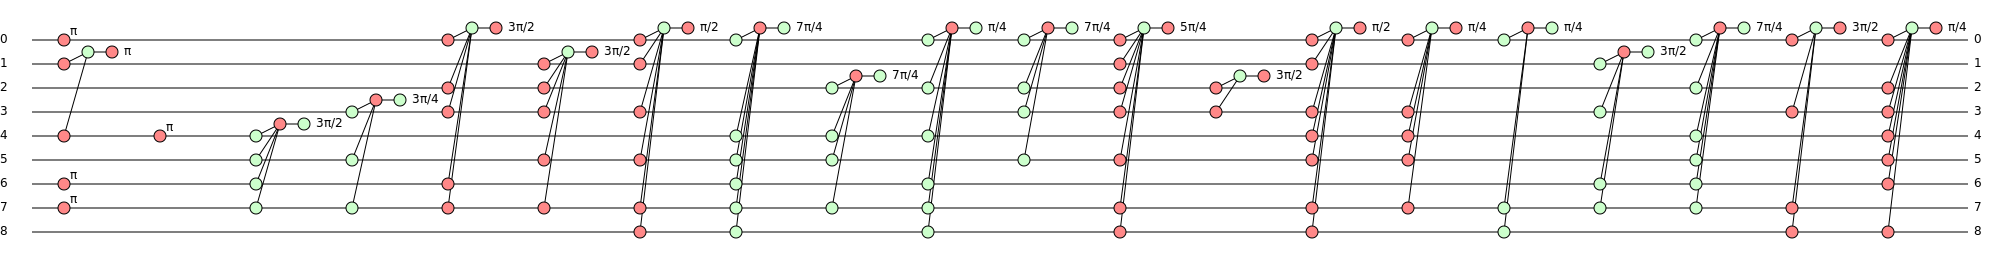

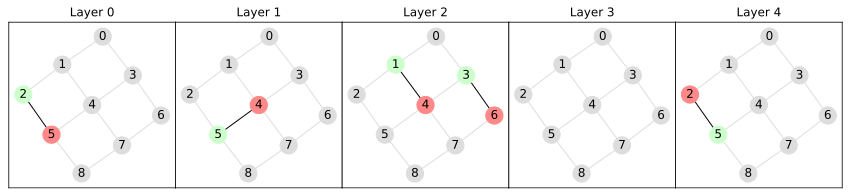

None

┌───────┐                                                    »
q_0: ──────────┤ Rx(π) ├────────────────────────────────────────────────────»
               └───────┘                       ┌───┐                        »
q_1: ───────■──────────────────────────────────┤ X ├────────────────────────»
     ┌───┐  │                                  └─┬─┘                        »
q_2: ┤ X ├──┼──────────────────────■─────────────┼──────────────────────────»
     └─┬─┘  │                      │             │                          »
q_3: ──┼────┼──────■───────────────┼─────────────┼──────────────────────────»
       │  ┌─┴─┐    │      ┌───┐    │  ┌───────┐  │  ┌───────┐┌───┐          »
q_4: ──┼──┤ X ├────┼──────┤ X ├────┼──┤ Rx(π) ├──■──┤ Rx(π) ├┤ X ├──■───────»
       │  └───┘    │      └─┬─┘  ┌─┴─┐└───────┘     └───────┘└─┬─┘  │       »
q_5: ──■───────────┼────────■────┤ X ├─────────────────────────■────┼───────»
                 ┌─┴─┐  ┌───────┐└───┘                              │  ┌───┐»
q_6: ────────────┤ X ├──┤ Rx(π) ├───────────────────────────────────┼──┤ X ├»
               ┌─┴───┴─┐└───────┘                                 ┌─┴─┐└─┬─┘»
q_7: ──────────┤ Rx(π) ├──────────────────────────────────────────┤ X ├──■──»
               └───────┘                                          └───┘     »
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                            ┌───┐     ┌───┐               »
«q_0: ───────────────────────────────────────┤ X ├──■──┤ X ├───────■───────»
«                                            └─┬─┘  │  └─┬─┘┌───┐  │       »
«q_1: ─────────────────────────────────────────┼────┼────■──┤ X ├──┼───────»
«                                              │    │       └─┬─┘  │       »
«q_2: ─────────────────────────────────────────┼────┼─────────■────┼────■──»
«                           ┌───┐┌──────────┐  │  ┌─┴─┐          ┌─┴─┐  │  »
«q_3: ──────────────────────┤ X ├┤ Rz(3π/4) ├──■──┤ X ├──────────┤ X ├──┼──»
«                 ┌───┐┌───┐└─┬─┘└──────────┘     └───┘          └───┘  │  »
«q_4: ────────────┤ X ├┤ X ├──■───────■─────────────────────────────────┼──»
«                 └─┬─┘└─┬─┘          │                               ┌─┴─┐»
«q_5: ──────────────┼────■────────────┼───────────────────────────────┤ X ├»
«     ┌──────────┐  │                 │                               └───┘»
«q_6: ┤ Rz(3π/2) ├──┼─────────────────┼────────────────────────────────────»
«     └──────────┘  │               ┌─┴─┐                                  »
«q_7: ──────────────■───────────────┤ X ├──────────────────────────────────»
«                                   └───┘                                  »
«q_8: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«                           ┌───┐                                           »
«q_0: ──────────────────────┤ X ├───────────────────────────────────────────»
«                           └─┬─┘┌───┐   ┌───┐                              »
«q_1: ───────────────────■────■──┤ X ├───┤ X ├──────────────────────■───────»
«     ┌──────────┐     ┌─┴─┐     └─┬─┘   └─┬─┘         ┌─────────┐  │       »
«q_2: ┤ Rx(3π/2) ├──■──┤ X ├───────┼───────■────────■──┤ Rx(π/2) ├──┼───────»
«     └──────────┘  │  └───┘       │                │  └─────────┘  │       »
«q_3: ──────────────┼──────────────┼────────────────┼───────────────┼───────»
«                   │              │  ┌──────────┐  │             ┌─┴─┐     »
«q_4: ──────────────┼──────────────■──┤ Rx(3π/2) ├──┼───────■─────┤ X ├──■──»
«                 ┌─┴─┐               └──────────┘┌─┴─┐     │     └───┘  │  »
«q_5: ────────────┤ X ├──■────────────────────────┤ X ├─────┼────────────┼──»
«                 └───┘  │                        └───┘     │            │  »
«q_6: ───────────────────┼──────────────────────────────

OrderedDict([('cx', 132), ('rx', 14), ('rz', 9)])
True


None

The new circuit is equal: True


In [15]:
opt_parity = run_annealer(orig_circuit, 5, "paritysynth")

Init cost: 169
Iter #01, new cost: 167
Iter #03, new cost: 162
Iter #04, new cost: 153
Iter #05, new cost: 145
Iter #21, new cost: 144
Final cost: 144


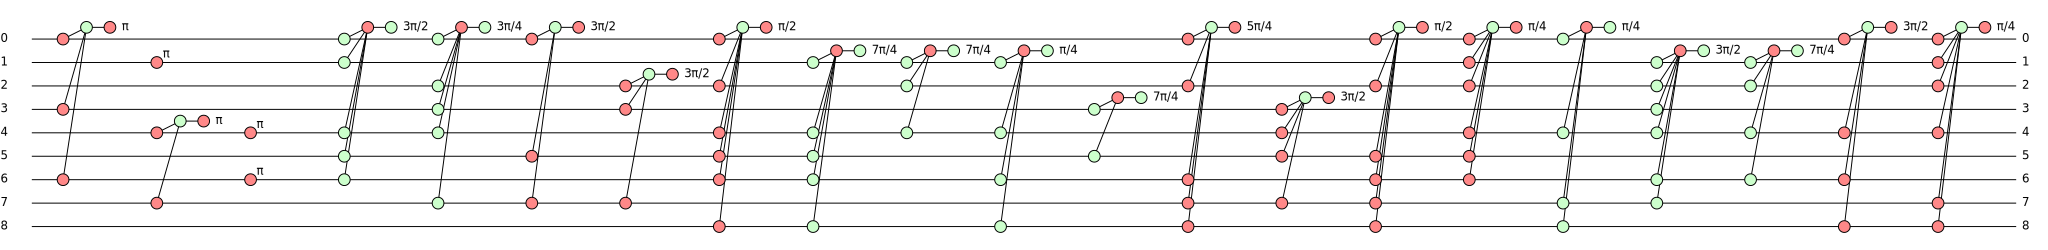

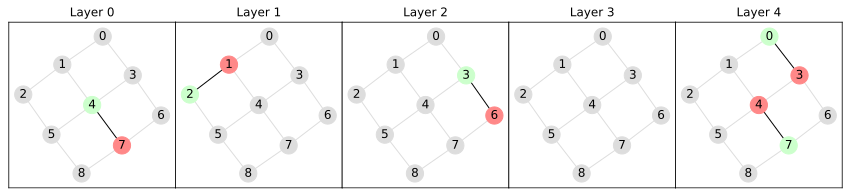

None

┌───┐                                        »
q_0: ──■──────────────────┤ X ├────■──────────────────────■────────────»
       │  ┌───┐┌───────┐  └─┬─┘  ┌─┴─┐                  ┌─┴─┐          »
q_1: ──┼──┤ X ├┤ Rx(π) ├────┼────┤ X ├─────────────■────┤ X ├──■───────»
       │  └─┬─┘└───────┘    │    └───┘             │    └───┘┌─┴─┐     »
q_2: ──┼────■───────────────┼──────────────────────┼─────────┤ X ├─────»
     ┌─┴─┐                  │           ┌───┐      │         └───┘     »
q_3: ┤ X ├──■───────────────■───────────┤ X ├──────┼──────■────────────»
     ├───┤  │           ┌───────┐┌───┐  └─┬─┘    ┌─┴─┐  ┌─┴─┐┌───┐     »
q_4: ┤ X ├──┼──────■────┤ Rx(π) ├┤ X ├────┼──────┤ X ├──┤ X ├┤ X ├──■──»
     └─┬─┘  │      │    └───────┘└─┬─┘    │      └───┘  └───┘└─┬─┘  │  »
q_5: ──┼────┼──────┼───────────────┼──────┼────────────────────■────┼──»
       │  ┌─┴─┐    │    ┌───────┐  │      │    ┌───────┐            │  »
q_6: ──┼──┤ X ├────┼────┤ Rx(π) ├──┼──────■────┤ Rx(π) ├────────────┼──»
       │  └───┘  ┌─┴─┐  └───────┘  │  ┌───────┐└───────┘          ┌─┴─┐»
q_7: ──■─────────┤ X ├─────────────■──┤ Rx(π) ├───────────────────┤ X ├»
                 └───┘                └───────┘                   └───┘»
q_8: ──────────────────────────────────────────────────────────────────»
                                                                       »
«                      ┌───┐                                                 »
«q_0: ─────────────────┤ X ├──────────────────────────────────────────────■──»
«                      └─┬─┘                                              │  »
«q_1: ───────────────────┼────────────────────────────────────────────────┼──»
«                        │              ┌───┐                             │  »
«q_2: ─────■─────────────┼──────────────┤ X ├─────────────────────────────┼──»
«          │             │              └─┬─┘┌───┐             ┌───┐    ┌─┴─┐»
«q_3: ─────┼────────■────■───────■────────┼──┤ X ├───────■─────┤ X ├────┤ X ├»
«          │      ┌─┴─┐        ┌─┴─┐      │  └─┬─┘┌───┐  │     └─┬─┘    ├───┤»
«q_4: ─────┼──────┤ X ├──■─────┤ X ├──────┼────■──┤ X ├──┼───────■──────┤ X ├»
«        ┌─┴─┐    └───┘┌─┴─┐┌──┴───┴───┐  │       └─┬─┘  │  ┌──────────┐└─┬─┘»
«q_5: ───┤ X ├─────────┤ X ├┤ Rz(3π/4) ├──■─────────■────┼──┤ Rx(3π/2) ├──■──»
«        └───┘         └───┘└──────────┘               ┌─┴─┐└──────────┘     »
«q_6: ─────────────────────────────────────────────────┤ X ├─────────────────»
«     ┌──────────┐                                     └───┘                 »
«q_7: ┤ Rz(3π/2) ├───────────────────────────────────────────────────────────»
«     └──────────┘                                                           »
«q_8: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«     ┌───┐                                                                 »
«q_0: ┤ X ├─────────────────────────────────────────────────────────■───────»
«     └─┬─┘                                                       ┌─┴─┐     »
«q_1: ──┼───────────────────────■──────────────────────────────■──┤ X ├──■──»
«       │                       │                              │  └───┘┌─┴─┐»
«q_2: ──┼───────────────────────┼──────────────────────────────┼───────┤ X ├»
«       │             ┌───┐     │                              │       └───┘»
«q_3: ──■───────■─────┤ X ├─────┼──────────────────────────────┼────────────»
«             ┌─┴─┐   └─┬─┘   ┌─┴─┐                     ┌───┐┌─┴─┐          »
«q_4: ────────┤ X ├─────┼─────┤ X ├──────■───────■──────┤ X ├┤ X ├──■───────»
«     ┌───┐   └───┘     │     └───┘      │     ┌─┴─┐    └─┬─┘└───┘  │       »
«q_5: ┤ X ├─────────────┼────────────────┼─────┤ X ├──────■─────────┼───────»
«     └─┬─┘             │  ┌──────────┐  │     └───┘                │       »
«q_6: ──┼───────────────■──┤ Rx(3π/2) ├──┼──────────────────────────┼────■──»
«       │                  └──────────┘┌─┴─┐┌─

OrderedDict([('cx', 144), ('rx', 14), ('rz', 9)])
True


None

The new circuit is equal: True


In [16]:
opt_gray = run_annealer(orig_circuit, 5, "steiner-graysynth")

In [17]:
opt_to_qiskit(opt_naive, "paritysynth")

┌───┐┌───────┐  ┌───┐                                   »
q_0: ─────────┤ X ├┤ Rx(π) ├──┤ X ├───────────────────────────────────»
              └─┬─┘└───────┘  └─┬─┘  ┌───┐                       ┌───┐»
q_1: ────■──────■───────────────■────┤ X ├───────────────────────┤ X ├»
       ┌─┴─┐                         └─┬─┘              ┌───────┐└─┬─┘»
q_2: ──┤ X ├────────────────────■──────■───────────■────┤ Rx(π) ├──┼──»
       └───┘                    │                  │    └───────┘  │  »
q_3: ───────────────────────────┼──────────────────┼────────■──────┼──»
                                │         ┌───┐    │      ┌─┴─┐    │  »
q_4: ────■─────────────■────────┼──────■──┤ X ├────┼──────┤ X ├────■──»
       ┌─┴─┐  ┌───┐    │      ┌─┴─┐  ┌─┴─┐└─┬─┘  ┌─┴─┐    └───┘       »
q_5: ──┤ X ├──┤ X ├────┼──────┤ X ├──┤ X ├──┼────┤ X ├────────────────»
     ┌─┴───┴─┐└─┬─┘    │      └───┘  └───┘  │    └───┘                »
q_6: ┤ Rx(π) ├──┼──────┼────────────────────┼─────────────────────────»
     └───────┘  │    ┌─┴─┐  ┌───────┐       │  ┌───────┐              »
q_7: ───────────┼────┤ X ├──┤ Rx(π) ├───────■──┤ Rx(π) ├──────────────»
                │    └───┘  └───────┘          └───────┘              »
q_8: ───────────■─────────────────────────────────────────────────────»
                                                                      »
«                      ┌───┐                 ┌──────────┐                      »
«q_0: ─────────────────┤ X ├──■───────■──────┤ Rx(3π/2) ├──────────────────────»
«     ┌──────────┐     └─┬─┘  │     ┌─┴─┐    └──────────┘                      »
«q_1: ┤ Rz(3π/4) ├───────┼────┼─────┤ X ├──────────────────────────────────────»
«     └──────────┘       │    │     └───┘                                      »
«q_2: ──────────────■────┼────┼────────────────────────────────────────────────»
«                   │    │  ┌─┴─┐                             ┌───┐   ┌───┐    »
«q_3: ─────■────────┼────■──┤ X ├──────────────────────────■──┤ X ├───┤ X ├────»
«          │        │       ├───┤                        ┌─┴─┐└─┬─┘   └─┬─┘    »
«q_4: ─────┼────────┼───────┤ X ├─────■───────────■──────┤ X ├──┼───────■──────»
«          │      ┌─┴─┐     └─┬─┘     │         ┌─┴─┐    └───┘  │              »
«q_5: ─────┼──────┤ X ├──■────■───────┼─────────┤ X ├───────────┼──────────────»
«        ┌─┴─┐    └───┘  │            │         └───┘           │  ┌──────────┐»
«q_6: ───┤ X ├──────■────┼────────────┼─────────────────────────■──┤ Rx(3π/2) ├»
«        └───┘    ┌─┴─┐  │          ┌─┴─┐                          └──────────┘»
«q_7: ────────────┤ X ├──┼────■─────┤ X ├──────────────────────────────────────»
«                 └───┘┌─┴─┐┌─┴─┐┌──┴───┴───┐                                  »
«q_8: ─────────────────┤ X ├┤ X ├┤ Rz(3π/2) ├──────────────────────────────────»
«                      └───┘└───┘└──────────┘                                  »
«                                                                        »
«q_0: ───────────────────────────────────────────────────────────────────»
«               ┌───┐                                          ┌───┐     »
«q_1: ──────────┤ X ├──────────────────────────────────────────┤ X ├─────»
«               └─┬─┘                                          └─┬─┘     »
«q_2: ────────────┼────────────────────■─────────────────■───────■───────»
«          ┌───┐  │                    │                 │          ┌───┐»
«q_3: ─────┤ X ├──┼────────────────────┼─────────────────┼──────────┤ X ├»
«          └─┬─┘  │  ┌─────────┐       │  ┌───┐          │     ┌───┐└─┬─┘»
«q_4: ──■────┼────■──┤ Rx(π/2) ├──■────┼──┤ X ├──────────┼─────┤ X ├──■──»
«       │    │       └─────────┘┌─┴─┐┌─┴─┐└─┬─┘        ┌─┴─┐   └─┬─┘     »
«q_5: ──┼────┼──────────────────┤ X ├┤ X ├──┼────■─────┤ X ├─────■───────»
«       │    │                  └───┘└───┘  │    │     └───┘             »
«q_6: ──┼────■──────────────────────────────┼────┼───────────────────────»
«     ┌─┴─┐                                 │    │       

OrderedDict([('cx', 146), ('rx', 14), ('rz', 9)])
True


None

The new circuit is equal: True


In [18]:
opt_to_qiskit(opt_parity, "naive")

┌───────┐                                                    »
q_0: ──────────┤ Rx(π) ├────────────────────────────────────────────────────»
               └───────┘                   ┌───────┐       ┌───┐            »
q_1: ───────■───────────────────────────■──┤ Rx(π) ├──■────┤ X ├────■───────»
     ┌───┐  │                           │  └───────┘  │    └─┬─┘  ┌─┴─┐     »
q_2: ┤ X ├──┼──────────────────────■────┼─────────────┼──────■────┤ X ├─────»
     └─┬─┘  │                      │    │             │           └───┘     »
q_3: ──┼────┼──────■───────────────┼────┼─────────────┼─────────────────────»
       │  ┌─┴─┐    │      ┌───┐    │  ┌─┴─┐         ┌─┴─┐┌───────┐┌───┐┌───┐»
q_4: ──┼──┤ X ├────┼──────┤ X ├────┼──┤ X ├─────────┤ X ├┤ Rx(π) ├┤ X ├┤ X ├»
       │  └───┘    │      └─┬─┘  ┌─┴─┐└───┘         └───┘└───────┘└─┬─┘└─┬─┘»
q_5: ──■───────────┼────────■────┤ X ├──────────────────────────────┼────■──»
                 ┌─┴─┐  ┌───────┐└───┘                              │       »
q_6: ────────────┤ X ├──┤ Rx(π) ├──■────────────────────────────────┼───────»
               ┌─┴───┴─┐└───────┘┌─┴─┐                              │       »
q_7: ──────────┤ Rx(π) ├─────────┤ X ├──────────────────────────────■───────»
               └───────┘         └───┘                                      »
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                                                          »
«q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_1: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_2: ─────────────────────────────────────────────────────────────────────»
«                                          ┌───┐┌──────────┐┌───┐          »
«q_3: ─────────────────────────────────────┤ X ├┤ Rz(3π/4) ├┤ X ├──────────»
«     ┌──────────┐┌───┐┌───┐     ┌───┐┌───┐└─┬─┘└──────────┘└─┬─┘┌───┐┌───┐»
«q_4: ┤ Rz(3π/2) ├┤ X ├┤ X ├──■──┤ X ├┤ X ├──■────────────────■──┤ X ├┤ X ├»
«     └──────────┘└─┬─┘└─┬─┘┌─┴─┐└─┬─┘└─┬─┘                      └─┬─┘└─┬─┘»
«q_5: ──────────────■────┼──┤ X ├──■────┼──────────────────────────┼────■──»
«                        │  └───┘       │                          │       »
«q_6: ───────────────────┼────■─────────┼──────────────────────────┼────■──»
«                        │  ┌─┴─┐       │                          │  ┌─┴─┐»
«q_7: ───────────────────■──┤ X ├───────■──────────────────────────■──┤ X ├»
«                           └───┘                                     └───┘»
«q_8: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«                         ┌──────────┐                         ┌───┐     ┌───┐»
«q_0: ────────────■────■──┤ Rx(3π/2) ├──■─────────■────────────┤ X ├──■──┤ X ├»
«                 │  ┌─┴─┐└──────────┘┌─┴─┐       │  ┌───┐     └─┬─┘  │  └─┬─┘»
«q_1: ────────────┼──┤ X ├────────────┤ X ├──■────┼──┤ X ├───────┼────┼────■──»
«                 │  └───┘            └───┘┌─┴─┐  │  └─┬─┘       │    │       »
«q_2: ────────────┼────────────────────────┤ X ├──┼────■────■────┼────┼───────»
«               ┌─┴─┐                      └───┘┌─┴─┐       │    │  ┌─┴─┐     »
«q_3: ───────■──┤ X ├───────────────────────────┤ X ├──■────┼────■──┤ X ├─────»
«            │  └───┘                           └───┘  │    │  ┌───┐└───┘     »
«q_4: ──■────┼─────────────────────────────────────────┼────┼──┤ X ├──■───────»
«     ┌─┴─┐  │                                         │  ┌─┴─┐└─┬─┘  │       »
«q_5: ┤ X ├──┼─────────────────────────────────────────┼──┤ X ├──┼────┼───────»
«     └───┘┌─┴─┐                                     ┌─┴─┐└───┘  │    │       »
«q_6: ─────┤ X ├──────────────

OrderedDict([('cx', 212), ('rx', 14), ('rz', 9)])
True


None

The new circuit is equal: True


In [19]:
opt_to_qiskit(opt_parity, "paritysynth", True)

┌───────┐                                                    »
q_0: ──────────┤ Rx(π) ├────────────────────────────────────────────────────»
               └───────┘                       ┌───┐                        »
q_1: ───────■──────────────────────────────────┤ X ├────────────────────────»
     ┌───┐  │                                  └─┬─┘                        »
q_2: ┤ X ├──┼──────────────────────■─────────────┼──────────────────────────»
     └─┬─┘  │                      │             │                          »
q_3: ──┼────┼──────■───────────────┼─────────────┼──────────────────────────»
       │  ┌─┴─┐    │      ┌───┐    │  ┌───────┐  │  ┌───────┐┌───┐          »
q_4: ──┼──┤ X ├────┼──────┤ X ├────┼──┤ Rx(π) ├──■──┤ Rx(π) ├┤ X ├──■───────»
       │  └───┘    │      └─┬─┘  ┌─┴─┐└───────┘     └───────┘└─┬─┘  │       »
q_5: ──■───────────┼────────■────┤ X ├─────────────────────────■────┼───────»
                 ┌─┴─┐  ┌───────┐└───┘                              │  ┌───┐»
q_6: ────────────┤ X ├──┤ Rx(π) ├───────────────────────────────────┼──┤ X ├»
               ┌─┴───┴─┐└───────┘                                 ┌─┴─┐└─┬─┘»
q_7: ──────────┤ Rx(π) ├──────────────────────────────────────────┤ X ├──■──»
               └───────┘                                          └───┘     »
q_8: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                            ┌───┐     ┌───┐               »
«q_0: ───────────────────────────────────────┤ X ├──■──┤ X ├───────■───────»
«                                            └─┬─┘  │  └─┬─┘┌───┐  │       »
«q_1: ─────────────────────────────────────────┼────┼────■──┤ X ├──┼───────»
«                                              │    │       └─┬─┘  │       »
«q_2: ─────────────────────────────────────────┼────┼─────────■────┼────■──»
«                           ┌───┐┌──────────┐  │  ┌─┴─┐          ┌─┴─┐  │  »
«q_3: ──────────────────────┤ X ├┤ Rz(3π/4) ├──■──┤ X ├──────────┤ X ├──┼──»
«                 ┌───┐┌───┐└─┬─┘└──────────┘     └───┘          └───┘  │  »
«q_4: ────────────┤ X ├┤ X ├──■───────■─────────────────────────────────┼──»
«                 └─┬─┘└─┬─┘          │                               ┌─┴─┐»
«q_5: ──────────────┼────■────────────┼───────────────────────────────┤ X ├»
«     ┌──────────┐  │                 │                               └───┘»
«q_6: ┤ Rz(3π/2) ├──┼─────────────────┼────────────────────────────────────»
«     └──────────┘  │               ┌─┴─┐                                  »
«q_7: ──────────────■───────────────┤ X ├──────────────────────────────────»
«                                   └───┘                                  »
«q_8: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«                           ┌───┐                                           »
«q_0: ──────────────────────┤ X ├───────────────────────────────────────────»
«                           └─┬─┘┌───┐   ┌───┐                              »
«q_1: ───────────────────■────■──┤ X ├───┤ X ├──────────────────────■───────»
«     ┌──────────┐     ┌─┴─┐     └─┬─┘   └─┬─┘         ┌─────────┐  │       »
«q_2: ┤ Rx(3π/2) ├──■──┤ X ├───────┼───────■────────■──┤ Rx(π/2) ├──┼───────»
«     └──────────┘  │  └───┘       │                │  └─────────┘  │       »
«q_3: ──────────────┼──────────────┼────────────────┼───────────────┼───────»
«                   │              │  ┌──────────┐  │             ┌─┴─┐     »
«q_4: ──────────────┼──────────────■──┤ Rx(3π/2) ├──┼───────■─────┤ X ├──■──»
«                 ┌─┴─┐               └──────────┘┌─┴─┐     │     └───┘  │  »
«q_5: ────────────┤ X ├──■────────────────────────┤ X ├─────┼────────────┼──»
«                 └───┘  │                        └───┘     │            │  »
«q_6: ───────────────────┼──────────────────────────────

OrderedDict([('cx', 121), ('rx', 14), ('rz', 9)])
True
{'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [8, 5, 0, 3, 6, 4, 7, 1, 2]}


Init cost: 154
Iter #00, new cost: 124
Iter #14, new cost: 114
Iter #25, new cost: 112
Final cost: 112


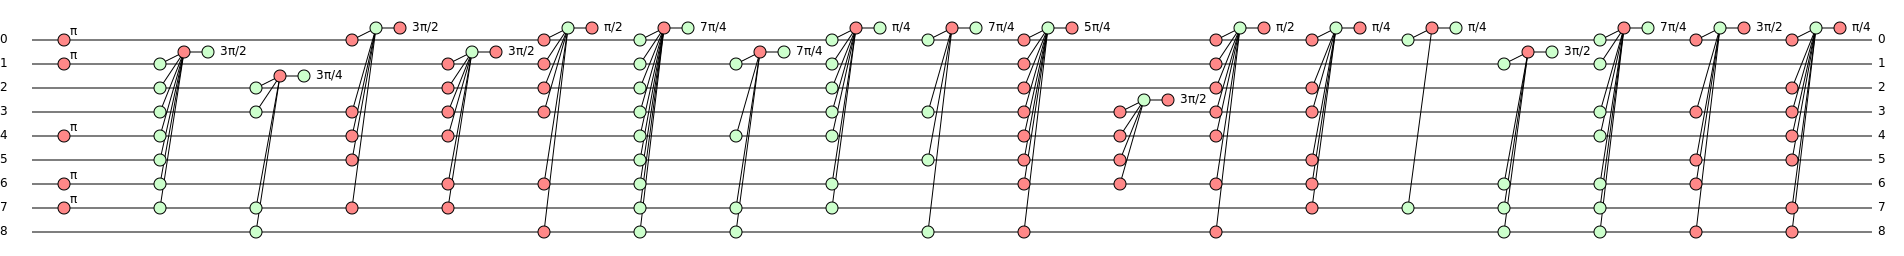

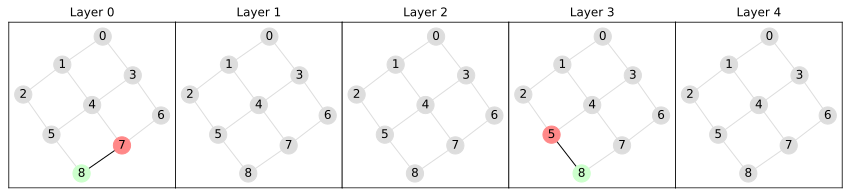

None

┌───────┐                                                ┌───┐            »
q_0: ┤ Rx(π) ├─────────────────────────■──────────────────────┤ X ├─────■──────»
     ├───────┤                         │  ┌───┐               └─┬─┘   ┌─┴─┐    »
q_1: ┤ Rx(π) ├─────────────────────────┼──┤ X ├──■──────────────┼─────┤ X ├────»
     └───────┘                         │  └─┬─┘┌─┴─┐            │     └───┘    »
q_2: ──────────────────────────────────┼────┼──┤ X ├──■─────────┼──────────────»
                         ┌───┐       ┌─┴─┐  │  └───┘  │  ┌───┐  │              »
q_3: ────────────────────┤ X ├────■──┤ X ├──┼─────────┼──┤ X ├──■──────────────»
     ┌───────┐           └─┬─┘  ┌─┴─┐├───┤  │         │  └─┬─┘                 »
q_4: ┤ Rx(π) ├─────────────┼────┤ X ├┤ X ├──■─────────┼────┼────■──────────────»
     └─┬───┬─┘             │    └───┘└─┬─┘          ┌─┴─┐  │    │  ┌──────────┐»
q_5: ──┤ X ├───────────────┼───────────┼────────────┤ X ├──┼────┼──┤ Rz(3π/2) ├»
       └─┬─┘  ┌───────┐    │           │       ┌───┐└───┘  │    │  └──────────┘»
q_6: ────┼────┤ Rx(π) ├────■───────────┼───────┤ X ├───────■────┼──────────────»
         │    └─┬───┬─┘┌───────┐       │  ┌───┐└─┬─┘          ┌─┴─┐            »
q_7: ────┼──────┤ X ├──┤ Rx(π) ├───────■──┤ X ├──■────────────┤ X ├────────────»
         │      └─┬─┘  └───────┘          └─┬─┘               └───┘            »
q_8: ────■────────■─────────────────────────■──────────────────────────────────»
                                                                               »
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«                      ┌───┐                                ┌───┐            »
«q_1: ──■──────────────┤ X ├──■─────────────────────────────┤ X ├────────────»
«     ┌─┴─┐┌──────────┐└─┬─┘┌─┴─┐                           └─┬─┘            »
«q_2: ┤ X ├┤ Rz(3π/4) ├──┼──┤ X ├─────────────────────────────┼──────────────»
«     └───┘└──────────┘  │  └───┘┌───┐                        │              »
«q_3: ───────────────────┼────■──┤ X ├────────────────────────┼──────────────»
«                        │  ┌─┴─┐└─┬─┘┌───┐                   │  ┌──────────┐»
«q_4: ───────────────────■──┤ X ├──┼──┤ X ├──────────────■────■──┤ Rx(3π/2) ├»
«                           └───┘  │  └─┬─┘              │       └──┬───┬───┘»
«q_5: ─────────────────────────────┼────┼────────────────┼──────────┤ X ├────»
«                                  │    │  ┌──────────┐  │          └─┬─┘    »
«q_6: ─────────────────────────────■────┼──┤ Rx(3π/2) ├──┼────────────┼──────»
«                                       │  └──────────┘┌─┴─┐          │      »
«q_7: ──────────────────────────────────■──────────────┤ X ├──■───────┼──────»
«                                                      └───┘┌─┴─┐     │      »
«q_8: ──────────────────────────────────────────────────────┤ X ├─────■──────»
«                                                           └───┘            »
«                                                                              »
«q_0: ───────────────────────────■────────────────────■───────■─────────────■──»
«                         ┌───┐  │                    │     ┌─┴─┐         ┌─┴─┐»
«q_1: ───────■────────────┤ X ├──┼────────────────────┼─────┤ X ├──────■──┤ X ├»
«            │            └─┬─┘  │                    │     └───┘    ┌─┴─┐└───┘»
«q_2: ───────┼──────────────┼────┼────────────────────┼──────────────┤ X ├──■──»
«            │       ┌───┐  │  ┌─┴─┐   ┌───┐        ┌─┴─┐            └───┘  │  »
«q_3: ──■────┼────■──┤ X ├──┼──┤ X ├───┤ X ├─────■──┤ X ├──────────────■────┼──»
«     ┌─┴─┐┌─┴─┐┌─┴─┐└─┬─┘  │  ├───┤   └─┬─┘   ┌─┴─┐└───┘              │    │  »
«q_4: ┤ X ├┤ X ├┤ X ├──■────■──┤ X ├─────┼─────┤ X ├──■────────────────┼────┼──»
«     └───┘└───┘└───┘          └─┬─┘     │     └───┘┌─┴─┐┌──────────┐  │  ┌─┴─┐»
«q_5: ───────────────────────────┼───────┼──────────┤ X ├┤ Rz(7π/4) ├──┼──

OrderedDict([('cx', 124), ('rx', 14), ('rz', 9)])
True


None

The new circuit is equal: True


┌───────┐                                                ┌───┐            »
q_0: ┤ Rx(π) ├─────────────────────────■──────────────────────┤ X ├─────■──────»
     ├───────┤                         │  ┌───┐               └─┬─┘   ┌─┴─┐    »
q_1: ┤ Rx(π) ├─────────────────────────┼──┤ X ├──■──────────────┼─────┤ X ├────»
     └───────┘                         │  └─┬─┘┌─┴─┐            │     └───┘    »
q_2: ──────────────────────────────────┼────┼──┤ X ├──■─────────┼──────────────»
                         ┌───┐       ┌─┴─┐  │  └───┘  │  ┌───┐  │              »
q_3: ────────────────────┤ X ├────■──┤ X ├──┼─────────┼──┤ X ├──■──────────────»
     ┌───────┐           └─┬─┘  ┌─┴─┐├───┤  │         │  └─┬─┘                 »
q_4: ┤ Rx(π) ├─────────────┼────┤ X ├┤ X ├──■─────────┼────┼────■──────────────»
     └─┬───┬─┘             │    └───┘└─┬─┘          ┌─┴─┐  │    │  ┌──────────┐»
q_5: ──┤ X ├───────────────┼───────────┼────────────┤ X ├──┼────┼──┤ Rz(3π/2) ├»
       └─┬─┘  ┌───────┐    │           │       ┌───┐└───┘  │    │  └──────────┘»
q_6: ────┼────┤ Rx(π) ├────■───────────┼───────┤ X ├───────■────┼──────────────»
         │    └─┬───┬─┘┌───────┐       │  ┌───┐└─┬─┘          ┌─┴─┐            »
q_7: ────┼──────┤ X ├──┤ Rx(π) ├───────■──┤ X ├──■────────────┤ X ├────────────»
         │      └─┬─┘  └───────┘          └─┬─┘               └───┘            »
q_8: ────■────────■─────────────────────────■──────────────────────────────────»
                                                                               »
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«                      ┌───┐                                ┌───┐            »
«q_1: ──■──────────────┤ X ├──■─────────────────────────────┤ X ├────────────»
«     ┌─┴─┐┌──────────┐└─┬─┘┌─┴─┐                           └─┬─┘            »
«q_2: ┤ X ├┤ Rz(3π/4) ├──┼──┤ X ├─────────────────────────────┼──────────────»
«     └───┘└──────────┘  │  └───┘┌───┐                        │              »
«q_3: ───────────────────┼────■──┤ X ├────────────────────────┼──────────────»
«                        │  ┌─┴─┐└─┬─┘┌───┐                   │  ┌──────────┐»
«q_4: ───────────────────■──┤ X ├──┼──┤ X ├──────────────■────■──┤ Rx(3π/2) ├»
«                           └───┘  │  └─┬─┘              │       └──┬───┬───┘»
«q_5: ─────────────────────────────┼────┼────────────────┼──────────┤ X ├────»
«                                  │    │  ┌──────────┐  │          └─┬─┘    »
«q_6: ─────────────────────────────■────┼──┤ Rx(3π/2) ├──┼────────────┼──────»
«                                       │  └──────────┘┌─┴─┐          │      »
«q_7: ──────────────────────────────────■──────────────┤ X ├──■───────┼──────»
«                                                      └───┘┌─┴─┐     │      »
«q_8: ──────────────────────────────────────────────────────┤ X ├─────■──────»
«                                                           └───┘            »
«                                                                              »
«q_0: ───────────────────────────■────────────────────■───────■─────────────■──»
«                         ┌───┐  │                    │     ┌─┴─┐         ┌─┴─┐»
«q_1: ───────■────────────┤ X ├──┼────────────────────┼─────┤ X ├──────■──┤ X ├»
«            │            └─┬─┘  │                    │     └───┘    ┌─┴─┐└───┘»
«q_2: ───────┼──────────────┼────┼────────────────────┼──────────────┤ X ├──■──»
«            │       ┌───┐  │  ┌─┴─┐   ┌───┐        ┌─┴─┐            └───┘  │  »
«q_3: ──■────┼────■──┤ X ├──┼──┤ X ├───┤ X ├─────■──┤ X ├──────────────■────┼──»
«     ┌─┴─┐┌─┴─┐┌─┴─┐└─┬─┘  │  ├───┤   └─┬─┘   ┌─┴─┐└───┘              │    │  »
«q_4: ┤ X ├┤ X ├┤ X ├──■────■──┤ X ├─────┼─────┤ X ├──■────────────────┼────┼──»
«     └───┘└───┘└───┘          └─┬─┘     │     └───┘┌─┴─┐┌──────────┐  │  ┌─┴─┐»
«q_5: ───────────────────────────┼───────┼──────────┤ X ├┤ Rz(7π/4) ├──┼──

OrderedDict([('cx', 112), ('rx', 14), ('rz', 9)])
True
{'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [6, 4, 2, 0, 7, 5, 8, 3, 1]}


In [20]:
opt_reallocate = run_annealer(orig_circuit, 5, "paritysynth", True)
opt_to_qiskit(opt_reallocate, "paritysynth", True)

Init cost: 169
Iter #00, new cost: 153
Iter #02, new cost: 131
Iter #03, new cost: 130
Iter #25, new cost: 129
Iter #26, new cost: 128
Iter #49, new cost: 126
Final cost: 126


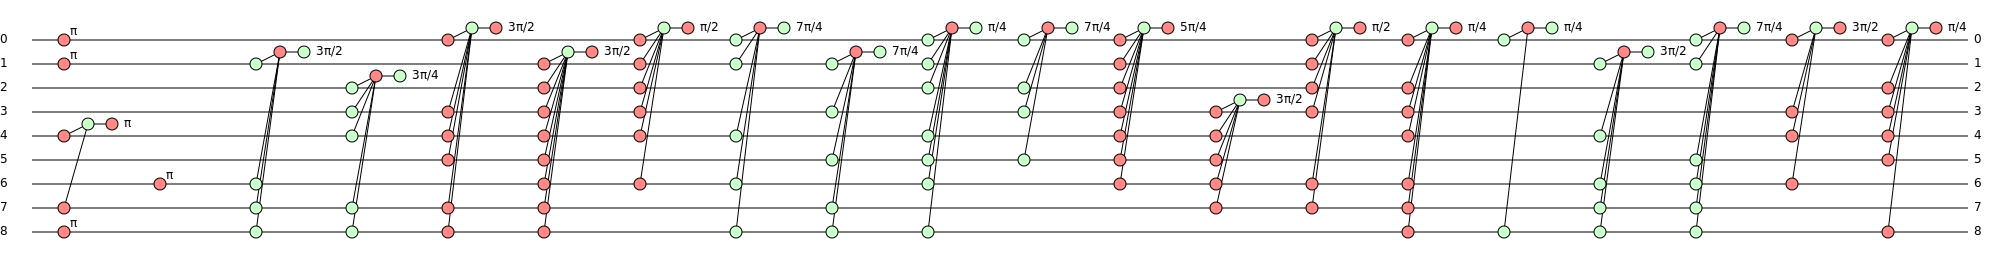

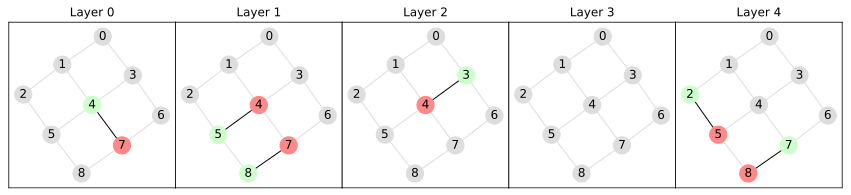

None

┌───────┐                                           ┌───┐            »
q_0: ─────┤ Rx(π) ├───────────────────────────────────────────┤ X ├────────────»
          ├───────┤                     ┌───┐       ┌───┐     └─┬─┘   ┌───┐    »
q_1: ─────┤ Rx(π) ├─────────────────────┤ X ├────■──┤ X ├──■────■─────┤ X ├────»
          └───────┘                     └─┬─┘    │  └─┬─┘  │  ┌───┐   └─┬─┘    »
q_2: ──■──────────────────────────────────┼──────┼────■────┼──┤ X ├─────■──────»
       │                                  │      │         │  └─┬─┘            »
q_3: ──┼──────■───────────────────────────┼──────┼─────────┼────┼───────■──────»
       │    ┌─┴─┐    ┌───┐       ┌───┐    │    ┌─┴─┐     ┌─┴─┐  │     ┌─┴─┐    »
q_4: ──┼────┤ X ├────┤ X ├────■──┤ X ├────■────┤ X ├──■──┤ X ├──┼─────┤ X ├────»
     ┌─┴─┐  └───┘    └─┬─┘    │  └─┬─┘         └───┘  │  └───┘  │     └───┘    »
q_5: ┤ X ├─────────────■──────┼────┼──────────────────┼─────────■──────────────»
     └───┘┌───────┐           │    │                  │                        »
q_6: ─────┤ Rx(π) ├───────────┼────┼──────────────────┼────■───────────────────»
          └─┬───┬─┘         ┌─┴─┐  │  ┌───────┐     ┌─┴─┐┌─┴─┐                 »
q_7: ──■────┤ X ├───────────┤ X ├──■──┤ Rx(π) ├─────┤ X ├┤ X ├──■──────────────»
     ┌─┴─┐  └─┬─┘  ┌───────┐└───┘     └───────┘     └───┘└───┘┌─┴─┐┌──────────┐»
q_8: ┤ X ├────■────┤ Rx(π) ├──────────────────────────────────┤ X ├┤ Rz(3π/2) ├»
     └───┘         └───────┘                                  └───┘└──────────┘»
«     ┌───┐                                                                 »
«q_0: ┤ X ├─────────────────────────────────────────────────────────■───────»
«     └─┬─┘                                               ┌───┐   ┌─┴─┐     »
«q_1: ──■───────────────────────────────────────────■─────┤ X ├───┤ X ├─────»
«                                ┌───┐              │     └─┬─┘   └───┘     »
«q_2: ───────────────────────────┤ X ├──────────────┼───────┼───────────────»
«          ┌───┐                 └─┬─┘              │       │     ┌───┐     »
«q_3: ─────┤ X ├───────────────────┼────────────────┼───────┼─────┤ X ├─────»
«          └─┬─┘                   │     ┌───┐    ┌─┴─┐     │     └─┬─┘┌───┐»
«q_4: ──■────┼─────────────────────┼─────┤ X ├────┤ X ├─────■───────■──┤ X ├»
«       │    │              ┌───┐  │     └─┬─┘    ├───┤                └─┬─┘»
«q_5: ──┼────┼──────────────┤ X ├──■───────■──────┤ X ├──────────────────■──»
«       │    │     ┌───┐    └─┬─┘                 └─┬─┘                     »
«q_6: ──┼────■─────┤ X ├──────┼─────────────────────┼───────────────────────»
«     ┌─┴─┐        └─┬─┘      │  ┌───┐              │                       »
«q_7: ┤ X ├──■───────■────────┼──┤ X ├──────────────┼───────────────────────»
«     └───┘┌─┴─┐┌──────────┐  │  └─┬─┘┌──────────┐  │  ┌─────────┐          »
«q_8: ─────┤ X ├┤ Rz(3π/4) ├──■────■──┤ Rx(3π/2) ├──■──┤ Rx(π/2) ├──────────»
«          └───┘└──────────┘          └──────────┘     └─────────┘          »
«                                  ┌───┐                    ┌───┐            »
«q_0: ─────────────────────────────┤ X ├──■─────────────────┤ X ├────────────»
«                                  └─┬─┘┌─┴─┐     ┌───┐     └─┬─┘            »
«q_1: ──────────────────────■────────■──┤ X ├─────┤ X ├──■────■──────────────»
«                           │           └───┘     └─┬─┘  │                   »
«q_2: ──────────────────────┼──────────────────■────■────┼───────────────────»
«                           │                  │         │                   »
«q_3: ─────■────────────────┼──────────────────┼─────────┼───────────────────»
«        ┌─┴─┐            ┌─┴─┐    ┌───┐┌───┐  │       ┌─┴─┐                 »
«q_4: ───┤ X ├──────■─────┤ X ├────┤ X ├┤ X ├──┼────■──┤ X ├─────────────────»
«     ┌──┴───┴───┐  │     └───┘    └─┬─┘└─┬─┘┌─┴─┐  │  └───┘                 »
«q_5: ┤ Rx(3π/2) ├──┼────────────────■────┼──┤ X ├──┼────■───────────────────»
«     └──────────┘  │                    

OrderedDict([('cx', 144), ('rx', 14), ('rz', 9)])
True


None

The new circuit is equal: True


┌───────┐                                           ┌───┐            »
q_0: ─────┤ Rx(π) ├───────────────────────────────────────────┤ X ├────────────»
          ├───────┤                     ┌───┐       ┌───┐     └─┬─┘   ┌───┐    »
q_1: ─────┤ Rx(π) ├─────────────────────┤ X ├────■──┤ X ├──■────■─────┤ X ├────»
          └───────┘                     └─┬─┘    │  └─┬─┘  │  ┌───┐   └─┬─┘    »
q_2: ─────────■───────────────────────────┼──────┼────■────┼──┤ X ├─────■──────»
              │                           │      │         │  └─┬─┘            »
q_3: ──■──────┼───────────────────────────┼──────┼─────────┼────┼───────■──────»
     ┌─┴─┐    │      ┌───┐       ┌───┐    │    ┌─┴─┐     ┌─┴─┐  │     ┌─┴─┐    »
q_4: ┤ X ├────┼──────┤ X ├────■──┤ X ├────■────┤ X ├──■──┤ X ├──┼─────┤ X ├────»
     └───┘  ┌─┴─┐    └─┬─┘    │  └─┬─┘         └───┘  │  └───┘  │     └───┘    »
q_5: ───────┤ X ├──────■──────┼────┼──────────────────┼─────────■──────────────»
          ┌─┴───┴─┐           │    │                  │                        »
q_6: ─────┤ Rx(π) ├───────────┼────┼──────────────────┼────■───────────────────»
          └───────┘         ┌─┴─┐  │  ┌───────┐     ┌─┴─┐┌─┴─┐                 »
q_7: ─────────■─────────────┤ X ├──■──┤ Rx(π) ├─────┤ X ├┤ X ├──■──────────────»
            ┌─┴─┐  ┌───────┐└───┘     └───────┘     └───┘└───┘┌─┴─┐┌──────────┐»
q_8: ───────┤ X ├──┤ Rx(π) ├──────────────────────────────────┤ X ├┤ Rz(3π/2) ├»
            └───┘  └───────┘                                  └───┘└──────────┘»
«     ┌───┐                                                                 »
«q_0: ┤ X ├─────────────────────────────────────────────────────────■───────»
«     └─┬─┘                                               ┌───┐   ┌─┴─┐     »
«q_1: ──■───────────────────────────────────────────■─────┤ X ├───┤ X ├─────»
«                                ┌───┐              │     └─┬─┘   └───┘     »
«q_2: ───────────────────────────┤ X ├──────────────┼───────┼───────────────»
«          ┌───┐                 └─┬─┘              │       │     ┌───┐     »
«q_3: ─────┤ X ├───────────────────┼────────────────┼───────┼─────┤ X ├─────»
«          └─┬─┘                   │     ┌───┐    ┌─┴─┐     │     └─┬─┘┌───┐»
«q_4: ──■────┼─────────────────────┼─────┤ X ├────┤ X ├─────■───────■──┤ X ├»
«       │    │              ┌───┐  │     └─┬─┘    ├───┤                └─┬─┘»
«q_5: ──┼────┼──────────────┤ X ├──■───────■──────┤ X ├──────────────────■──»
«       │    │     ┌───┐    └─┬─┘                 └─┬─┘                     »
«q_6: ──┼────■─────┤ X ├──────┼─────────────────────┼───────────────────────»
«     ┌─┴─┐        └─┬─┘      │  ┌───┐              │                       »
«q_7: ┤ X ├──■───────■────────┼──┤ X ├──────────────┼───────────────────────»
«     └───┘┌─┴─┐┌──────────┐  │  └─┬─┘┌──────────┐  │  ┌─────────┐          »
«q_8: ─────┤ X ├┤ Rz(3π/4) ├──■────■──┤ Rx(3π/2) ├──■──┤ Rx(π/2) ├──────────»
«          └───┘└──────────┘          └──────────┘     └─────────┘          »
«                                  ┌───┐                    ┌───┐            »
«q_0: ─────────────────────────────┤ X ├──■─────────────────┤ X ├────────────»
«                                  └─┬─┘┌─┴─┐     ┌───┐     └─┬─┘            »
«q_1: ──────────────────────■────────■──┤ X ├─────┤ X ├──■────■──────────────»
«                           │           └───┘     └─┬─┘  │                   »
«q_2: ──────────────────────┼──────────────────■────■────┼───────────────────»
«                           │                  │         │                   »
«q_3: ─────■────────────────┼──────────────────┼─────────┼───────────────────»
«        ┌─┴─┐            ┌─┴─┐    ┌───┐┌───┐  │       ┌─┴─┐                 »
«q_4: ───┤ X ├──────■─────┤ X ├────┤ X ├┤ X ├──┼────■──┤ X ├─────────────────»
«     ┌──┴───┴───┐  │     └───┘    └─┬─┘└─┬─┘┌─┴─┐  │  └───┘                 »
«q_5: ┤ Rx(3π/2) ├──┼────────────────■────┼──┤ X ├──┼────■───────────────────»
«     └──────────┘  │                    

OrderedDict([('cx', 126), ('rx', 14), ('rz', 9)])
True
{'initial_layout': [0, 1, 2, 3, 4, 5, 6, 8, 7], 'final_layout': [4, 6, 2, 3, 8, 7, 1, 0, 5]}


In [21]:
opt_reallocate = run_annealer(orig_circuit, 5, "steiner-graysynth", True)
opt_to_qiskit(opt_reallocate, "steiner-graysynth", True)

In [22]:
from pauliopt.phase import iter_anneal, reverse_traversal_anneal, reverse_traversal_then_anneal

def compile_iter_anneal(circuit, topology, n_iter, n_anneal_iter, cx_blocks, method, verbose=False):
    return iter_anneal(circuit, topology, n_iter, n_anneal_iter, cx_blocks, verbose=verbose, method=method)

def compile_reverse_traversal_anneal(circuit, topology, n_iter, n_anneal_iter, cx_blocks, method, verbose=False):
    return reverse_traversal_anneal(circuit, topology, n_iter, n_anneal_iter, cx_blocks, verbose=verbose, method=method)

def compile_reverse_traversal_then_anneal(circuit, topology, n_iter, n_anneal_iter, cx_blocks, method, verbose=False):
    return reverse_traversal_then_anneal(circuit, topology, n_iter, n_anneal_iter, cx_blocks, verbose=verbose, method=method)

In [23]:
iter_anneal_circuit = compile_iter_anneal(orig_circuit, topology, 10, 10, 5, "paritysynth", True)
display(iter_anneal_circuit.draw())
print(iter_anneal_circuit.count_ops())
print(iter_anneal_circuit.metadata)

0 131 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [2, 4, 3, 6, 5, 8, 1, 7, 0]}
1 121 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [6, 4, 5, 7, 8, 1, 0, 2, 3]}
2 129 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [5, 6, 7, 0, 2, 4, 8, 1, 3]}
3 127 {'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [0, 7, 2, 8, 3, 6, 4, 1, 5]}
4 133 {'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [7, 1, 8, 4, 6, 0, 3, 5, 2]}
5 123 {'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [1, 4, 8, 6, 2, 7, 5, 3, 0]}
6 127 {'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [0, 2, 5, 4, 6, 7, 3, 1, 8]}
7 119 {'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [8, 0, 4, 6, 1, 7, 2, 3, 5]}
8 122 {'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [4, 0, 8, 7, 5, 1, 2, 3, 6]}
9 115 {'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [1, 7, 0, 6, 2, 8, 3, 4, 5]}


┌───┐                                              »
q_0: ────■──────────────────┤ X ├───────────■──────────────────────────────────»
       ┌─┴─┐  ┌───┐┌───────┐└─┬─┘┌───────┐  │                                  »
q_1: ──┤ X ├──┤ X ├┤ Rx(π) ├──■──┤ Rx(π) ├──┼────■─────────────────────────────»
       └───┘  └─┬─┘└───────┘     └───────┘  │  ┌─┴─┐                           »
q_2: ───────────■───────────────────────────┼──┤ X ├───────────────────────────»
                                          ┌─┴─┐├───┤                           »
q_3: ─────────────────────────────────────┤ X ├┤ X ├──■────────────────────────»
     ┌───────┐                            └───┘└─┬─┘┌─┴─┐┌───┐                 »
q_4: ┤ Rx(π) ├───────────────────────────────────┼──┤ X ├┤ X ├──■──────────────»
     └───────┘                                   │  └───┘└─┬─┘┌─┴─┐┌──────────┐»
q_5: ────────────────────────────────────────────┼─────────┼──┤ X ├┤ Rz(3π/2) ├»
     ┌───────┐                                   │         │  ├───┤└──────────┘»
q_6: ┤ Rx(π) ├───────────────────────────────────■─────────┼──┤ X ├────────────»
     ├───────┤                                             │  └─┬─┘            »
q_7: ┤ Rx(π) ├─────────────────────────────────────────────■────■──────────────»
     └───────┘                                                                 »
q_8: ──────────────────────────────────────────────────────────────────────────»
                                                                               »
«          ┌───┐                                                           »
«q_0: ─────┤ X ├──■────────────────────────────────────────────────────────»
«          └─┬─┘┌─┴─┐                 ┌───┐     ┌───┐                      »
«q_1: ───────┼──┤ X ├──■──────────────┤ X ├─────┤ X ├───────────────────■──»
«            │  └───┘┌─┴─┐┌──────────┐└─┬─┘     └─┬─┘                   │  »
«q_2: ───────┼───────┤ X ├┤ Rz(3π/4) ├──┼─────────┼─────────────────────┼──»
«     ┌───┐  │       └───┘└──────────┘  │         │                     │  »
«q_3: ┤ X ├──■──────────────────────────┼─────────┼─────────────────────┼──»
«     └─┬─┘                             │  ┌───┐  │                   ┌─┴─┐»
«q_4: ──┼───────────────────────────────■──┤ X ├──■────────────────■──┤ X ├»
«       │                                  └─┬─┘                   │  └───┘»
«q_5: ──┼────────────────────────────────────┼─────────────────────┼───────»
«       │                                    │       ┌──────────┐  │       »
«q_6: ──■────────────────────────────────────┼────■──┤ Rx(3π/2) ├──┼───────»
«                                            │  ┌─┴─┐└──────────┘┌─┴─┐┌───┐»
«q_7: ───────────────────────────────────────■──┤ X ├────────────┤ X ├┤ X ├»
«                                               └───┘            └───┘└─┬─┘»
«q_8: ──────────────────────────────────────────────────────────────────■──»
«                                                                          »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«          ┌──────────┐                                                     »
«q_1: ──■──┤ Rx(3π/2) ├──────────────────────────────────────────────────■──»
«     ┌─┴─┐└──────────┘                    ┌─────────┐                   │  »
«q_2: ┤ X ├──────────────■──────────────■──┤ Rx(π/2) ├───────────────────┼──»
«     ├───┤              │              │  └─────────┘                   │  »
«q_3: ┤ X ├─────■────────┼──────────────┼────────────────────────────────┼──»
«     └─┬─┘   ┌─┴─┐      │  ┌───┐       │                         ┌───┐┌─┴─┐»
«q_4: ──┼─────┤ X ├──────┼──┤ X ├───────┼───────■─────────────────┤ X ├┤ X ├»
«       │     └───┘    ┌─┴─┐└─┬─┘     ┌─┴─┐   ┌─┴─┐   ┌──────────┐└─┬─┘├───┤»
«q_5: ──┼──────────────┤ X ├──┼────■──┤ X ├───┤ X ├───┤ Rz(7π/4) ├──┼──┤ X ├»
«       │              └───┘  │    │  └───┘   └───┘   └──────────┘  │  └─┬─┘»
«q_6: ──■───

OrderedDict([('cx', 115), ('rx', 14), ('rz', 9)])
{'initial_layout': [0, 1, 2, 4, 3, 5, 6, 7, 8], 'final_layout': [1, 7, 0, 6, 2, 8, 3, 4, 5]}


In [24]:
iter_anneal_circuit = compile_iter_anneal(orig_circuit, topology, 10, 10, 5, "steiner-graysynth", True)
display(iter_anneal_circuit.draw())
print(iter_anneal_circuit.count_ops())
print(iter_anneal_circuit.metadata)

0 150 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [6, 4, 8, 5, 0, 3, 1, 7, 2]}
1 144 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [7, 0, 6, 5, 1, 4, 2, 3, 8]}
2 119 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [7, 8, 2, 0, 3, 1, 4, 6, 5]}
3 130 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [0, 7, 1, 8, 6, 3, 2, 5, 4]}
4 129 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [0, 4, 3, 2, 8, 5, 6, 7, 1]}
5 134 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [8, 5, 2, 0, 1, 4, 3, 7, 6]}
6 118 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [6, 5, 4, 2, 1, 8, 3, 0, 7]}
7 149 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [4, 3, 1, 0, 2, 6, 5, 8, 7]}
8 134 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [2, 8, 7, 0, 6, 3, 5, 1, 4]}
9 146 {'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [5, 8, 0, 2, 6, 4, 1, 3, 7]}


┌───────┐                                                                 »
q_0: ┤ Rx(π) ├────────────────────────────────────────■────────────────────────»
     └───────┘         ┌───┐         ┌───┐     ┌───┐  │          ┌───┐         »
q_1: ────■─────────────┤ X ├─────────┤ X ├──■──┤ X ├──┼──────────┤ X ├──────■──»
       ┌─┴─┐    ┌───┐  └─┬─┘┌───────┐└─┬─┘  │  └─┬─┘  │          └─┬─┘      │  »
q_2: ──┤ X ├────┤ X ├────■──┤ Rx(π) ├──┼────┼────■────┼────────────┼────────┼──»
       └───┘    └─┬─┘       └───────┘  │    │       ┌─┴─┐          │        │  »
q_3: ─────────────┼────────────────────┼────┼────■──┤ X ├──────────┼────────┼──»
     ┌───────┐    │                    │  ┌─┴─┐┌─┴─┐├───┤          │      ┌─┴─┐»
q_4: ┤ Rx(π) ├────┼────────────────────■──┤ X ├┤ X ├┤ X ├──■───────■──────┤ X ├»
     └───────┘    │                       └───┘└───┘└─┬─┘  │              └───┘»
q_5: ────■────────■───────────────────────────────────■────┼───────────────────»
         │    ┌───────┐                                    │                   »
q_6: ────┼────┤ Rx(π) ├────────────────────────────────────┼───────────────────»
         │    ├───────┤                                  ┌─┴─┐┌──────────┐     »
q_7: ────┼────┤ Rx(π) ├──────────────────────────────────┤ X ├┤ Rz(3π/4) ├─────»
       ┌─┴─┐  └───────┘                                  └───┘└──────────┘     »
q_8: ──┤ X ├───────────────────────────────────────────────────────────────────»
       └───┘                                                                   »
«          ┌───┐                                                        ┌───┐»
«q_0: ──■──┤ X ├─────────────────────────────────────────────────────■──┤ X ├»
«     ┌─┴─┐└─┬─┘┌───┐                                                │  └─┬─┘»
«q_1: ┤ X ├──■──┤ X ├────────────────────────────────────────────────┼────■──»
«     └───┘     └─┬─┘   ┌───┐                                        │       »
«q_2: ────────────■─────┤ X ├────────────────────────────────────────┼───────»
«                       └─┬─┘         ┌──────────┐   ┌───┐         ┌─┴─┐     »
«q_3: ────────────────────┼────────■──┤ Rx(3π/2) ├───┤ X ├──────■──┤ X ├──■──»
«     ┌───┐               │        │  └──────────┘   └─┬─┘      │  └───┘┌─┴─┐»
«q_4: ┤ X ├──■────────────┼────────┼───────────────────┼────────┼───────┤ X ├»
«     └─┬─┘  │            │        │     ┌───┐         │        │       └───┘»
«q_5: ──■────┼────────────■────────┼─────┤ X ├─────────┼────────┼────────────»
«            │                   ┌─┴─┐   └─┬─┘         │      ┌─┴─┐┌───┐     »
«q_6: ───────┼────■──────────────┤ X ├─────┼───────────■──────┤ X ├┤ X ├──■──»
«          ┌─┴─┐┌─┴─┐┌──────────┐└───┘     │                  └───┘└─┬─┘┌─┴─┐»
«q_7: ─────┤ X ├┤ X ├┤ Rz(3π/2) ├──────────┼─────────────────────────■──┤ X ├»
«          └───┘└───┘└──────────┘          │      ┌──────────┐          └───┘»
«q_8: ─────────────────────────────────────■──────┤ Rx(3π/2) ├───────────────»
«                                                 └──────────┘               »
«                                                                           »
«q_0: ────────────■─────────────────────────────────────────────────────────»
«          ┌───┐┌─┴─┐                                                       »
«q_1: ──■──┤ X ├┤ X ├───────────────────────────────────■───────────────────»
«     ┌─┴─┐└─┬─┘├───┤                                   │                   »
«q_2: ┤ X ├──■──┤ X ├───────────────────────────────────┼───────────────────»
«     └───┘     └─┬─┘                                   │                   »
«q_3: ────────────┼─────────────────────────────────────┼───────────────────»
«                 │                                   ┌─┴─┐   ┌───┐         »
«q_4: ────────────┼────────────────────────────■──────┤ X ├───┤ X ├──────■──»
«                 │  ┌─────────┐               │      └───┘   └─┬─┘      │  »
«q_5: ────────────■──┤ Rx(π/2) ├──■────────────┼────────────────■────────┼──»
«                    └───────

OrderedDict([('cx', 118), ('rx', 14), ('rz', 9)])
{'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'final_layout': [6, 5, 4, 2, 1, 8, 3, 0, 7]}


In [25]:
rt_anneal_circuit = compile_reverse_traversal_anneal(orig_circuit, topology, 10, 10, 5, "paritysynth", True)
display(rt_anneal_circuit.draw())
print(rt_anneal_circuit.count_ops())
print(rt_anneal_circuit.metadata)

0 126 {'initial_layout': [6, 1, 0, 5, 7, 4, 8, 2, 3], 'final_layout': [8, 1, 6, 4, 2, 7, 3, 0, 5]} False
1 122 {'initial_layout': [7, 6, 3, 4, 2, 1, 0, 5, 8], 'final_layout': [3, 2, 5, 7, 8, 0, 4, 1, 6]} True
2 119 {'initial_layout': [8, 7, 2, 6, 0, 5, 3, 4, 1], 'final_layout': [5, 3, 4, 2, 8, 7, 1, 6, 0]} False
3 124 {'initial_layout': [0, 8, 1, 5, 4, 7, 2, 6, 3], 'final_layout': [4, 6, 0, 1, 7, 3, 8, 2, 5]} True
4 112 {'initial_layout': [2, 4, 1, 0, 6, 7, 3, 5, 8], 'final_layout': [2, 7, 4, 6, 8, 3, 0, 5, 1]} False
5 126 {'initial_layout': [2, 4, 1, 0, 6, 7, 3, 5, 8], 'final_layout': [2, 4, 1, 0, 6, 7, 3, 5, 8]} True
6 126 {'initial_layout': [2, 4, 1, 0, 6, 7, 3, 5, 8], 'final_layout': [2, 4, 1, 0, 6, 7, 3, 5, 8]} False
7 131 {'initial_layout': [5, 3, 0, 8, 4, 2, 1, 6, 7], 'final_layout': [0, 8, 7, 5, 1, 3, 6, 2, 4]} True
8 115 {'initial_layout': [5, 4, 8, 6, 2, 0, 1, 3, 7], 'final_layout': [2, 5, 8, 6, 3, 0, 4, 7, 1]} False
9 117 {'initial_layout': [6, 8, 0, 1, 3, 2, 4, 5, 7], 'fina

┌───────┐                                                             »
q_0: ┤ Rx(π) ├────────────────■────────────────────────────────────────────»
     ├───────┤                │  ┌───┐                                     »
q_1: ┤ Rx(π) ├────────────────┼──┤ X ├──■──────────────────────────────────»
     └───────┘                │  └─┬─┘┌─┴─┐                                »
q_2: ─────────────────────────┼────┼──┤ X ├──■─────────────────────────────»
                ┌───┐       ┌─┴─┐  │  └───┘  │                        ┌───┐»
q_3: ───────────┤ X ├────■──┤ X ├──┼─────────┼────────────────────────┤ X ├»
     ┌───────┐  └─┬─┘  ┌─┴─┐├───┤  │         │                        └─┬─┘»
q_4: ┤ Rx(π) ├────┼────┤ X ├┤ X ├──■─────────┼──────────────────────────┼──»
     └───────┘    │    └───┘└─┬─┘          ┌─┴─┐┌───┐┌──────────┐       │  »
q_5: ─────────────┼───────────┼────────────┤ X ├┤ X ├┤ Rz(3π/2) ├───────┼──»
     ┌───────┐    │           │            └───┘└─┬─┘└──────────┘┌───┐  │  »
q_6: ┤ Rx(π) ├────■───────────┼───────────────────┼──────────────┤ X ├──■──»
     └─┬───┬─┘┌───────┐       │                   │     ┌───┐    └─┬─┘     »
q_7: ──┤ X ├──┤ Rx(π) ├───────■───────────────────┼─────┤ X ├──────■───────»
       └─┬─┘  └───────┘                           │     └─┬─┘              »
q_8: ────■────────────────────────────────────────■───────■────────────────»
                                                                           »
«     ┌───┐                                                                »
«q_0: ┤ X ├──■─────────────────────────────────────────────────────────────»
«     └─┬─┘┌─┴─┐                 ┌───┐                                ┌───┐»
«q_1: ──┼──┤ X ├──■──────────────┤ X ├──■─────────────────────────────┤ X ├»
«       │  └───┘┌─┴─┐┌──────────┐└─┬─┘┌─┴─┐                           └─┬─┘»
«q_2: ──┼───────┤ X ├┤ Rz(3π/4) ├──┼──┤ X ├─────────────────────────────┼──»
«       │       └───┘└──────────┘  │  └───┘┌───┐                        │  »
«q_3: ──■──────────────────────────┼────■──┤ X ├────────────────────────┼──»
«                                  │  ┌─┴─┐└─┬─┘┌───┐                   │  »
«q_4: ──■──────────────────────────■──┤ X ├──┼──┤ X ├──────────────■────■──»
«       │                             └───┘  │  └─┬─┘              │       »
«q_5: ──┼────────────────────────────────────┼────┼────────────────┼───────»
«       │                                    │    │  ┌──────────┐  │       »
«q_6: ──┼────────────────────────────────────■────┼──┤ Rx(3π/2) ├──┼───────»
«     ┌─┴─┐                                       │  └──────────┘┌─┴─┐     »
«q_7: ┤ X ├───────────────────────────────────────■──────────────┤ X ├──■──»
«     └───┘                                                      └───┘┌─┴─┐»
«q_8: ────────────────────────────────────────────────────────────────┤ X ├»
«                                                                     └───┘»
«                                                                    »
«q_0: ───────────────────────────────────────■────────────────────■──»
«                                     ┌───┐  │                    │  »
«q_1: ───────────────────■────────────┤ X ├──┼────────────────────┼──»
«                        │            └─┬─┘  │                    │  »
«q_2: ───────────────────┼──────────────┼────┼────────────────────┼──»
«                        │       ┌───┐  │  ┌─┴─┐   ┌───┐        ┌─┴─┐»
«q_3: ──────────────■────┼────■──┤ X ├──┼──┤ X ├───┤ X ├─────■──┤ X ├»
«     ┌──────────┐┌─┴─┐┌─┴─┐┌─┴─┐└─┬─┘  │  ├───┤   └─┬─┘   ┌─┴─┐└───┘»
«q_4: ┤ Rx(3π/2) ├┤ X ├┤ X ├┤ X ├──■────■──┤ X ├─────┼─────┤ X ├──■──»
«     └──┬───┬───┘└───┘└───┘└───┘          └─┬─┘     │     └───┘┌─┴─┐»
«q_5: ───┤ X ├───────────────────────────────┼───────┼──────────┤ X ├»
«        └─┬─┘                               │       │     ┌───┐└───┘»
«q_6: ─────┼─────────────────────────────────┼───────■─────┤ X ├─────»
«          │                                 │  ┌─────────┐└─┬─┘┌───┐»
«q_7: ─────┼──

OrderedDict([('cx', 112), ('rx', 14), ('rz', 9)])
{'initial_layout': [2, 4, 1, 0, 6, 7, 3, 5, 8], 'final_layout': [2, 7, 4, 6, 8, 3, 0, 5, 1]}


In [26]:
rt_anneal_circuit = compile_reverse_traversal_anneal(orig_circuit, topology, 10, 10, 5, "steiner-graysynth", True)
display(rt_anneal_circuit.draw())
print(rt_anneal_circuit.count_ops())
print(rt_anneal_circuit.metadata)

0 154 {'initial_layout': [3, 1, 2, 5, 8, 7, 6, 4, 0], 'final_layout': [5, 1, 2, 7, 0, 4, 6, 8, 3]} False
1 146 {'initial_layout': [2, 0, 4, 5, 6, 3, 7, 1, 8], 'final_layout': [7, 2, 6, 0, 5, 3, 1, 8, 4]} True
2 132 {'initial_layout': [8, 3, 4, 2, 0, 6, 5, 1, 7], 'final_layout': [6, 0, 1, 2, 8, 3, 4, 5, 7]} False
3 143 {'initial_layout': [4, 2, 0, 5, 3, 1, 8, 6, 7], 'final_layout': [1, 4, 2, 7, 6, 3, 8, 0, 5]} True
4 119 {'initial_layout': [6, 7, 0, 4, 5, 2, 3, 8, 1], 'final_layout': [4, 6, 7, 3, 1, 2, 0, 5, 8]} False
5 135 {'initial_layout': [1, 4, 2, 6, 3, 7, 0, 5, 8], 'final_layout': [3, 6, 5, 2, 0, 4, 8, 1, 7]} True
6 144 {'initial_layout': [4, 8, 3, 5, 1, 6, 7, 2, 0], 'final_layout': [0, 6, 7, 3, 8, 5, 2, 4, 1]} False
7 145 {'initial_layout': [4, 8, 3, 5, 1, 6, 7, 2, 0], 'final_layout': [4, 8, 3, 5, 1, 6, 7, 2, 0]} True
8 146 {'initial_layout': [8, 6, 5, 7, 3, 4, 1, 2, 0], 'final_layout': [8, 4, 0, 7, 6, 2, 5, 3, 1]} False
9 133 {'initial_layout': [8, 7, 4, 1, 6, 3, 0, 2, 5], 'fina

┌───────┐                                                                 »
q_0: ┤ Rx(π) ├─────────────────────────────────────────────────────────────────»
     └───────┘  ┌───┐           ┌───┐     ┌───┐             ┌───┐              »
q_1: ────■──────┤ X ├───────────┤ X ├──■──┤ X ├─────────────┤ X ├──────■───────»
       ┌─┴─┐    └─┬─┘  ┌───────┐└─┬─┘  │  └─┬─┘             └─┬─┘      │       »
q_2: ──┤ X ├──────■────┤ Rx(π) ├──┼────┼────■─────────────────┼────────┼───────»
       └───┘           └───────┘  │    │            ┌───┐     │        │       »
q_3: ────■────────────────────────┼────┼────■───────┤ X ├─────┼────────┼────■──»
         │    ┌───────┐           │  ┌─┴─┐┌─┴─┐     └─┬─┘     │      ┌─┴─┐┌─┴─┐»
q_4: ────┼────┤ Rx(π) ├───────────■──┤ X ├┤ X ├──■────┼───────■──────┤ X ├┤ X ├»
         │    └───────┘              └───┘└───┘  │    │              └───┘└───┘»
q_5: ────┼───────────────────────────────────────┼────┼────────────────────────»
       ┌─┴─┐  ┌───────┐                          │    │                        »
q_6: ──┤ X ├──┤ Rx(π) ├──────────────────────────┼────■────────────────────────»
       └───┘  └─┬───┬─┘                        ┌─┴─┐                           »
q_7: ────■──────┤ X ├──────────────────────────┤ X ├──■────────────────────────»
       ┌─┴─┐    └─┬─┘  ┌───────┐               └───┘┌─┴─┐┌──────────┐          »
q_8: ──┤ X ├──────■────┤ Rx(π) ├────────────────────┤ X ├┤ Rz(3π/4) ├──────────»
       └───┘           └───────┘                    └───┘└──────────┘          »
«                  ┌───┐                                                     »
«q_0: ─────────────┤ X ├─────────────────────────────────────────────────────»
«                  └─┬─┘                             ┌───┐              ┌───┐»
«q_1: ───────────────┼─────────────────────────■─────┤ X ├──────────────┤ X ├»
«                    │                         │     └─┬─┘              └─┬─┘»
«q_2: ───────────────┼─────────────────────────┼───────┼──────────────────┼──»
«          ┌───┐     │         ┌───┐           │       │                  │  »
«q_3: ─────┤ X ├─────■─────────┤ X ├───────────┼───────┼──────────────────┼──»
«          └─┬─┘   ┌───┐       └─┬─┘    ┌───┐┌─┴─┐     │           ┌───┐  │  »
«q_4: ──■────■─────┤ X ├─────────■──────┤ X ├┤ X ├─────■────────■──┤ X ├──■──»
«     ┌─┴─┐        └─┬─┘    ┌──────────┐└─┬─┘└───┘            ┌─┴─┐└─┬─┘     »
«q_5: ┤ X ├──■───────■──────┤ Rx(3π/2) ├──┼───────────────────┤ X ├──┼───────»
«     └───┘  │              └──────────┘  │  ┌───┐            └───┘  │  ┌───┐»
«q_6: ───────┼────────────────────────────┼──┤ X ├───────────────────┼──┤ X ├»
«            │                            │  └─┬─┘┌──────────┐       │  └─┬─┘»
«q_7: ───────┼────────────────────────────■────■──┤ Rx(3π/2) ├───────■────■──»
«          ┌─┴─┐┌──────────┐                      └──────────┘               »
«q_8: ─────┤ X ├┤ Rz(3π/2) ├─────────────────────────────────────────────────»
«          └───┘└──────────┘                                                 »
«                             ┌───┐                                          »
«q_0: ─────────────■──────────┤ X ├──────────────────────────────────────────»
«                ┌─┴─┐        └─┬─┘         ┌───┐                            »
«q_1: ─────■─────┤ X ├──■───────┼────────■──┤ X ├────────────────────────────»
«          │     └───┘  │       │        │  └─┬─┘                            »
«q_2: ─────┼────────────┼───────┼────────┼────■──────────────────────────────»
«          │            │       │        │                          ┌───┐    »
«q_3: ─────┼────────────┼───────■────────┼────────────────────■─────┤ X ├────»
«        ┌─┴─┐        ┌─┴─┐            ┌─┴─┐                ┌─┴─┐   └─┬─┘    »
«q_4: ───┤ X ├─────■──┤ X ├─────■──────┤ X ├──────────■─────┤ X ├─────■──────»
«        └───┘   ┌─┴─┐└───┘   ┌─┴─┐    └───┘          │     └───┘            »
«q_5: ───────────┤ X ├──■─────┤ X ├──────■────────────┼──────────────────────»
«                

OrderedDict([('cx', 119), ('rx', 14), ('rz', 9)])
{'initial_layout': [6, 7, 0, 4, 5, 2, 3, 8, 1], 'final_layout': [4, 6, 7, 3, 1, 2, 0, 5, 8]}


In [27]:
rt_circuit = compile_reverse_traversal_then_anneal(orig_circuit, topology, 10, 10, 5, "paritysynth", True)
display(rt_circuit.draw())
print(rt_circuit.count_ops())
print(rt_circuit.metadata)

0 122 {'final_layout': [7, 4, 6, 1, 3, 0, 8, 5, 2], 'initial_layout': [4, 0, 8, 5, 7, 1, 2, 3, 6]} False
1 122 {'final_layout': [3, 7, 2, 0, 5, 4, 6, 1, 8], 'initial_layout': [7, 4, 6, 1, 3, 0, 8, 5, 2]} True
2 122 {'final_layout': [5, 3, 8, 4, 1, 7, 2, 0, 6], 'initial_layout': [3, 7, 2, 0, 5, 4, 6, 1, 8]} False
3 122 {'final_layout': [1, 5, 6, 7, 0, 3, 8, 4, 2], 'initial_layout': [5, 3, 8, 4, 1, 7, 2, 0, 6]} True
4 122 {'final_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'initial_layout': [1, 5, 6, 7, 0, 3, 8, 4, 2]} False
5 122 {'final_layout': [4, 0, 8, 5, 7, 1, 2, 3, 6], 'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8]} True
6 122 {'final_layout': [7, 4, 6, 1, 3, 0, 8, 5, 2], 'initial_layout': [4, 0, 8, 5, 7, 1, 2, 3, 6]} False
7 122 {'final_layout': [3, 7, 2, 0, 5, 4, 6, 1, 8], 'initial_layout': [7, 4, 6, 1, 3, 0, 8, 5, 2]} True
8 122 {'final_layout': [5, 3, 8, 4, 1, 7, 2, 0, 6], 'initial_layout': [3, 7, 2, 0, 5, 4, 6, 1, 8]} False
9 122 {'final_layout': [1, 5, 6, 7, 0, 3, 8, 4, 2], 'initia

┌───────┐                                                            »
q_0: ─────┤ Rx(π) ├────────────────────────────────────────────────────────────»
          ├───────┤                       ┌───┐                                »
q_1: ─────┤ Rx(π) ├──────────────────■────┤ X ├──■─────────────────────────────»
          └───────┘                  │    └─┬─┘  │                             »
q_2: ────────────────────────────────┼──────■────┼─────────────────────────────»
                                     │           │  ┌───┐┌──────────┐┌───┐     »
q_3: ────────────────────────────────┼───────────┼──┤ X ├┤ Rz(3π/4) ├┤ X ├──■──»
                            ┌───┐  ┌─┴─┐       ┌─┴─┐└─┬─┘└──────────┘└─┬─┘┌─┴─┐»
q_4: ─────────■─────────────┤ X ├──┤ X ├───────┤ X ├──■────────────────┼──┤ X ├»
              │             └─┬─┘  └───┘       └───┘                   │  └───┘»
q_5: ──■──────┼───────────────┼────────────────────────────────────────┼───────»
       │      │    ┌───────┐  │                                        │       »
q_6: ──┼──────┼────┤ Rx(π) ├──┼────────────────────────────────────────■───────»
       │    ┌─┴─┐  ├───────┤  │  ┌───────┐                                     »
q_7: ──┼────┤ X ├──┤ Rx(π) ├──■──┤ Rx(π) ├─────────────────────────────────────»
     ┌─┴─┐  └───┘  └───────┘     └───────┘                                     »
q_8: ┤ X ├─────────────────────────────────────────────────────────────────────»
     └───┘                                                                     »
«                                                    ┌───┐               »
«q_0: ───────────────────────────────────────────────┤ X ├───────■───────»
«                                               ┌───┐└─┬─┘┌───┐  │       »
«q_1: ──■────────────────────────────────────■──┤ X ├──■──┤ X ├──┼───────»
«       │                         ┌───┐    ┌─┴─┐└─┬─┘     └─┬─┘  │       »
«q_2: ──┼─────────────────────────┤ X ├────┤ X ├──■─────────■────┼────■──»
«       │  ┌───┐                  └─┬─┘    └───┘               ┌─┴─┐  │  »
«q_3: ──┼──┤ X ├───────■────────────┼──────────────────────────┤ X ├──┼──»
«     ┌─┴─┐└─┬─┘┌───┐  │            │                          └───┘  │  »
«q_4: ┤ X ├──┼──┤ X ├──┼────■───────┼─────────────────────────────────┼──»
«     └───┘  │  └─┬─┘  │    │       │                               ┌─┴─┐»
«q_5: ───────┼────■────┼────┼───────■────────■──────────────────────┤ X ├»
«            │       ┌─┴─┐  │                │                      └───┘»
«q_6: ───────■───────┤ X ├──┼────────────────┼───────────────────────────»
«                    └───┘┌─┴─┐┌──────────┐  │                           »
«q_7: ────────────────────┤ X ├┤ Rz(3π/2) ├──┼───────────────────────────»
«                         └───┘└──────────┘┌─┴─┐                         »
«q_8: ─────────────────────────────────────┤ X ├─────────────────────────»
«                                          └───┘                         »
«                      ┌───┐                  ┌───┐                         »
«q_0: ─────────────────┤ X ├──────────────────┤ X ├─────────────────────────»
«                 ┌───┐└─┬─┘┌───┐     ┌───┐   └─┬─┘    ┌───┐                »
«q_1: ────────────┤ X ├──■──┤ X ├─────┤ X ├─────■──────┤ X ├────────────────»
«     ┌──────────┐└─┬─┘     └─┬─┘     └─┬─┘┌──────────┐└─┬─┘                »
«q_2: ┤ Rx(3π/2) ├──■─────────■────■────┼──┤ Rx(3π/2) ├──┼──────────────────»
«     └──┬───┬───┘                 │    │  └──────────┘  │                  »
«q_3: ───┤ X ├─────────────────────┼────┼────────────────┼──────────────────»
«        └─┬─┘                     │    │                │       ┌─────────┐»
«q_4: ─────┼───────────────────────┼────■────────────────■────■──┤ Rx(π/2) ├»
«          │                     ┌─┴─┐                      ┌─┴─┐└─────────┘»
«q_5: ─────┼─────────────────────┤ X ├──■───────────────────┤ X ├───────────»
«          │                     └───┘  │                   └───┘           »
«q_6: ─────■────────────────────

OrderedDict([('cx', 131), ('rx', 14), ('rz', 9)])
{'initial_layout': [3, 4, 2, 1, 7, 0, 6, 5, 8], 'final_layout': [4, 5, 6, 3, 0, 1, 8, 7, 2]}


In [28]:
rt_circuit = compile_reverse_traversal_then_anneal(orig_circuit, topology, 10, 10, 5, "steiner-graysynth", True)
display(rt_circuit.draw())
print(rt_circuit.count_ops())
print(rt_circuit.metadata)

0 151 {'final_layout': [5, 1, 2, 7, 0, 4, 6, 8, 3], 'initial_layout': [3, 1, 2, 5, 8, 7, 6, 4, 0]} False
1 151 {'final_layout': [7, 1, 2, 4, 3, 8, 6, 0, 5], 'initial_layout': [5, 1, 2, 7, 0, 4, 6, 8, 3]} True
2 151 {'final_layout': [4, 1, 2, 8, 5, 0, 6, 3, 7], 'initial_layout': [7, 1, 2, 4, 3, 8, 6, 0, 5]} False
3 151 {'final_layout': [8, 1, 2, 0, 7, 3, 6, 5, 4], 'initial_layout': [4, 1, 2, 8, 5, 0, 6, 3, 7]} True
4 151 {'final_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'initial_layout': [8, 1, 2, 0, 7, 3, 6, 5, 4]} False
5 151 {'final_layout': [3, 1, 2, 5, 8, 7, 6, 4, 0], 'initial_layout': [0, 1, 2, 3, 4, 5, 6, 7, 8]} True
6 151 {'final_layout': [5, 1, 2, 7, 0, 4, 6, 8, 3], 'initial_layout': [3, 1, 2, 5, 8, 7, 6, 4, 0]} False
7 151 {'final_layout': [7, 1, 2, 4, 3, 8, 6, 0, 5], 'initial_layout': [5, 1, 2, 7, 0, 4, 6, 8, 3]} True
8 151 {'final_layout': [4, 1, 2, 8, 5, 0, 6, 3, 7], 'initial_layout': [7, 1, 2, 4, 3, 8, 6, 0, 5]} False
9 151 {'final_layout': [8, 1, 2, 0, 7, 3, 6, 5, 4], 'initia

┌───────┐                                                                »
q_0: ┤ Rx(π) ├────────────────────────────────────────────────────────────────»
     ├───────┤                                                       ┌───┐    »
q_1: ┤ Rx(π) ├───────────────────────────■─────────────────────■─────┤ X ├────»
     └───────┘┌───┐                    ┌─┴─┐                   │     └─┬─┘    »
q_2: ─────────┤ X ├─────────────■──────┤ X ├─────────■─────────┼───────┼──────»
              └─┬─┘             │      └───┘         │         │       │      »
q_3: ────■──────┼───────────────┼────────■───────────┼─────────┼───────┼──────»
       ┌─┴─┐    │  ┌───────┐    │        │           │       ┌─┴─┐     │      »
q_4: ──┤ X ├────┼──┤ Rx(π) ├────┼────────┼───────────┼────■──┤ X ├─────■──────»
       └───┘    │  └───────┘  ┌─┴─┐      │         ┌─┴─┐┌─┴─┐└───┘            »
q_5: ───────────■─────────────┤ X ├──────┼──────■──┤ X ├┤ X ├─────────────────»
                              ├───┤    ┌─┴─┐    │  ├───┤└───┘        ┌───┐    »
q_6: ───────────■─────────────┤ X ├────┤ X ├────┼──┤ X ├──■──────────┤ X ├────»
              ┌─┴─┐  ┌───┐    └─┬─┘  ┌─┴───┴─┐  │  └─┬─┘┌─┴─┐        └─┬─┘    »
q_7: ────■────┤ X ├──┤ X ├──────■────┤ Rx(π) ├──┼────■──┤ X ├──■───────■──────»
       ┌─┴─┐  └───┘  └─┬─┘  ┌───────┐└───────┘┌─┴─┐     └───┘┌─┴─┐┌──────────┐»
q_8: ──┤ X ├───────────■────┤ Rx(π) ├─────────┤ X ├──────────┤ X ├┤ Rz(3π/4) ├»
       └───┘                └───────┘         └───┘          └───┘└──────────┘»
«                                        ┌───┐         ┌───┐                 »
«q_0: ───────────────────────────────────┤ X ├─────────┤ X ├──■──────────────»
«                                        └─┬─┘         └─┬─┘  │     ┌───┐    »
«q_1: ─────────────────────────────────────┼─────────────┼────┼─────┤ X ├────»
«                       ┌───┐              │             │    │     └─┬─┘    »
«q_2: ──────────────────┤ X ├──────────────┼─────────────┼────┼───────┼──────»
«                       └─┬─┘    ┌───┐     │      ┌───┐  │  ┌─┴─┐     │      »
«q_3: ────────────■───────┼──────┤ X ├─────■──────┤ X ├──■──┤ X ├─────┼──────»
«               ┌─┴─┐     │      └─┬─┘            └─┬─┘     ├───┤     │      »
«q_4: ───────■──┤ X ├─────┼────────┼────────────────■────■──┤ X ├─────■──────»
«          ┌─┴─┐└───┘     │        │                   ┌─┴─┐└─┬─┘            »
«q_5: ──■──┤ X ├──────────■────────┼───────────────────┤ X ├──┼──────────────»
«       │  └───┘                   │  ┌──────────┐     └───┘  │              »
«q_6: ──┼────■─────────────────────■──┤ Rx(3π/2) ├────────────┼──────────────»
«       │  ┌─┴─┐                      └──────────┘            │  ┌──────────┐»
«q_7: ──┼──┤ X ├──■───────────────────────────────────────────■──┤ Rx(3π/2) ├»
«     ┌─┴─┐└───┘┌─┴─┐┌──────────┐                                └──────────┘»
«q_8: ┤ X ├─────┤ X ├┤ Rz(3π/2) ├────────────────────────────────────────────»
«     └───┘     └───┘└──────────┘                                            »
«        ┌───┐                  ┌───┐                                      »
«q_0: ───┤ X ├──────────────────┤ X ├─────■────────────────────────────────»
«        └─┬─┘                  └─┬─┘     │                                »
«q_1: ─────■──────────────────────┼───────┼────────────────────────────────»
«                                 │       │                                »
«q_2: ────────────────────────────┼───────┼────────────────────────────────»
«                                 │     ┌─┴─┐                              »
«q_3: ─────────────■─────────■────■─────┤ X ├─────■────────────────────────»
«     ┌─────────┐┌─┴─┐       │          └───┘   ┌─┴─┐                      »
«q_4: ┤ Rx(π/2) ├┤ X ├──■────┼──────────────────┤ X ├──────────────────────»
«     └─────────┘└───┘┌─┴─┐  │                  ├───┤                      »
«q_5: ────────────────┤ X ├──┼────■─────────────┤ X ├──■───────────────────»
«                     └───┘┌─┴─┐  │             └─┬─┘  │    

OrderedDict([('cx', 132), ('rx', 14), ('rz', 9)])
{'initial_layout': [7, 2, 6, 8, 0, 3, 1, 4, 5], 'final_layout': [0, 6, 1, 4, 8, 3, 2, 5, 7]}


# Experiments
We now generate many random phase circuits and compile them in different ways to the same architecture and count their respective CNOT costs.

In [29]:
import pandas as pd
import time

In [30]:
from pytket.architecture import Architecture
from pytket.transform import Transform
from pytket.passes import SequencePass, DecomposeBoxes, FullPeepholeOptimise, CXMappingPass, NaivePlacementPass, KAKDecomposition, CliffordSimp, SynthesiseTK, RebaseTket, RemoveRedundancies, SimplifyInitial
from pytket.predicates import CompilationUnit
from pytket.placement import Placement
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

def compile_with_tket(circuit, topology):
    architecture = Architecture([[v for v in c] for c in topology._couplings])
    placer = Placement(architecture)
    compilation_pass = SequencePass([DecomposeBoxes(), FullPeepholeOptimise(), CXMappingPass(architecture, placer), 
                                    NaivePlacementPass(architecture), KAKDecomposition(), CliffordSimp(allow_swaps=False),
                                    SynthesiseTK(), RebaseTket(), RemoveRedundancies(), SimplifyInitial(allow_classical=False, create_all_qubits=True)])
    tkcirc = qiskit_to_tk(circuit)
    cu = CompilationUnit(tkcirc)
    compilation_pass.apply(cu)
    
    return tk_to_qiskit(cu.circuit)

In [31]:
from qiskit import transpile

def compile_with_qiskit(circuit, topology):
     return transpile(circuit, 
                      optimization_level=3, 
                      basis_gates=['u1', 'u2', 'u3', 'cx'], 
                      coupling_map=[[v for v in c] for c in topology._couplings])
    

In [32]:
def count_cnots(circuit):
    ops = circuit.count_ops()
    if "cx" in ops:
        return ops["cx"]
    return 0

def compile_time_and_count(compiler_function, *args):
    start_time = time.process_time()
    compiled_circuit = compiler_function(*args)
    elapsed_time = time.process_time() - start_time
    return count_cnots(compiled_circuit), elapsed_time

def compile_anneal(circuit, topology, cx_block, method, n_iter, reallocate):
    opt =  OptimizedPhaseCircuit(circuit, topology, cx_block=cx_block, method=method)
    opt.anneal(n_iter, schedule=("geometric", 1, 1e-5), method=method, reallocate=reallocate)
    return opt.to_qiskit(method)

def generate_and_compile(n_gadgets, topology, cx_block=5, n_iter=100):
    data = {}
    circuit = PhaseCircuit.random(topology.num_qubits, n_gadgets, min_legs=int(np.round(np.sqrt(topology.num_qubits)))).simplified()
    qiskit_circuit = circuit.to_qiskit(topology, "naive")
    data["original"] = count_cnots(qiskit_circuit)
    data["qiskit"], data["qiskit time"] = compile_time_and_count(compile_with_qiskit, qiskit_circuit, topology)
    data["tket"], data["tket time"] = compile_time_and_count(compile_with_tket, qiskit_circuit, topology)
    data["parity"], data["parity time"] = compile_time_and_count(circuit.to_qiskit, topology, "paritysynth")
    data["graysynth"], data["graysynth time"] = compile_time_and_count(circuit.to_qiskit, topology, "steiner-graysynth")
    data["annealer"], data["annealer time"] = compile_time_and_count(compile_anneal, circuit, topology, cx_block, "naive", n_iter, False)
    #data["annealer+graysynth"], data["annealer+graysynth time"] = compile_time_and_count(compile_anneal, circuit, topology, cx_block, "steiner-graysynth", n_iter, True)
    #data["annealer+parity"], data["annealer+parity time"] = compile_time_and_count(compile_anneal, circuit, topology, cx_block, "paritysynth", n_iter, False)
    #data["annealer+permrowcol"], data["annealer+permrowcol time"] = compile_time_and_count(compile_anneal, circuit, topology, cx_block, "paritysynth", n_iter, True)
    #data["annealer+iter"], data["annealer+iter time"] = compile_time_and_count(compile_iter_anneal, circuit, topology, int(np.round(np.sqrt(n_iter))), int(np.round(np.sqrt(n_iter))), cx_block, "paritysynth")
    #data["annealer+RT+parity"], data["annealer+RT+parity time"] = compile_time_and_count(compile_reverse_traversal_anneal, circuit, topology, int(np.round(np.sqrt(n_iter))), int(np.round(np.sqrt(n_iter))), cx_block, "paritysynth")
    data["annealer+RT+graysynth"], data["annealer+RT+graysynth time"] = compile_time_and_count(compile_reverse_traversal_anneal, circuit, topology, int(np.round(np.sqrt(n_iter))), int(np.round(np.sqrt(n_iter))), cx_block, "steiner-graysynth")
    data["parity+RT->annealer"], data["parity+RT->annealer time"] = compile_time_and_count(compile_reverse_traversal_then_anneal, circuit, topology, int(np.round(np.sqrt(n_iter))), int(np.round(np.sqrt(n_iter))), cx_block, "paritysynth")
    data["graysynth+RT->annealer"], data["graysynth+RT->annealer time"] = compile_time_and_count(compile_reverse_traversal_then_anneal, circuit, topology, int(np.round(np.sqrt(n_iter))), int(np.round(np.sqrt(n_iter))), cx_block, "steiner-graysynth")
    #data["parity+RT"], data["parity+RT time"] = compile_time_and_count(compile_reverse_traversal_anneal, circuit, topology, n_iter, 0, 0, "paritysynth")
    data["graysynth+RT"], data["graysynth+RT time"] = compile_time_and_count(compile_reverse_traversal_anneal, circuit, topology, n_iter, 0, 0, "steiner-graysynth")
    return data

In [33]:
from qiskit.providers.fake_provider import FakeSingapore, FakeJohannesburg, FakeYorktown, FakeMelbourne, FakeValencia

In [34]:
n = 100
print("Results for", n, "randomly generated phase circuits")
gadgets = [1,2,5,10,50,100]
results = []
devices = {
    "Singapore": Topology.from_qiskit_backend(FakeSingapore()),
    "Johannesburg": Topology.from_qiskit_backend(FakeJohannesburg()),
    "Melbourne": Topology.from_qiskit_backend(FakeMelbourne()),
    "Yorktown": Topology.from_qiskit_backend(FakeYorktown()),
    "Valencia": Topology.from_qiskit_backend(FakeValencia())
}
start_time = time.process_time()
for n_gadgets in gadgets:
    for name, topology in devices.items():
        print(name, n_gadgets, "Passed time since start",time.process_time() - start_time)
        for _ in range(n):
            data = generate_and_compile(n_gadgets, topology)
            data["n_gadgets"] = n_gadgets
            data["device"] = name
            data["n_qubits"] = topology.num_qubits
            results.append(data)
print("Total passed time since start:", time.process_time() - start_time)
df = pd.DataFrame(results)
df.to_csv("preliminary results.csv")
df.groupby(["device","n_gadgets"]).mean()

Results for 100 randomly generated phase circuits
Singapore 1 Passed time since start 6.500000000642103e-05


/Users/griendar/miniforge3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/griendar/miniforge3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Johannesburg 1 Passed time since start 699.428435
Melbourne 1 Passed time since start 1432.501125
Yorktown 1 Passed time since start 1785.478611
Valencia 1 Passed time since start 1844.549811
Singapore 2 Passed time since start 1905.609151
Johannesburg 2 Passed time since start 3101.384877
Melbourne 2 Passed time since start 4442.543422
Yorktown 2 Passed time since start 5079.039436999999
Valencia 2 Passed time since start 5172.179013
Singapore 5 Passed time since start 5272.00585
Johannesburg 5 Passed time since start 7850.038172
Melbourne 5 Passed time since start 10590.209725
Yorktown 5 Passed time since start 11764.152083
Valencia 5 Passed time since start 11919.957171
Singapore 10 Passed time since start 12082.144664000001
Johannesburg 10 Passed time since start 16556.350459999998
Melbourne 10 Passed time since start 21295.735193999997
Yorktown 10 Passed time since start 23203.351542999997
Valencia 10 Passed time since start 23429.822597
Singapore 50 Passed time since start 23671.

original   qiskit  qiskit time     tket  tket time  \
device       n_gadgets                                                       
Johannesburg 1             27.10    26.81     0.053221    21.33   0.456726   
             2             55.16    53.74     0.118849    38.37   0.921487   
             5            137.88   132.82     0.273469    92.71   2.080426   
             10           278.36   269.10     0.549690   184.88   4.338898   
             50          1366.58  1311.36     3.290666   946.56  23.106061   
             100         2730.04  2619.86     6.619282  1919.77  46.397210   
Melbourne    1             19.68    19.35     0.041324    14.93   0.313462   
             2             38.80    37.27     0.080353    29.09   0.668789   
             5             94.44    88.85     0.177912    63.94   1.396264   
             10           183.78   172.09     0.351561   123.71   2.695325   
             50           919.24   849.91     2.309798   622.18  14.591512   
             100         1833.14  1690.40     4.739148  1223.35  27.150623   
Singapore    1             27.12    26.80     0.054627    20.63   0.460159   
             2             53.46    52.00     0.111620    36.10   0.858040   
             5            132.88   126.11     0.269629    90.57   2.059490   
             10           270.46   256.31     0.553148   180.10   4.093014   
             50          1384.62  1295.42     3.856676   938.44  21.638021   
             100         2733.66  2561.52     8.111527  1904.46  47.526201   
Valencia     1              5.70     5.46     0.012987     3.92   0.085834   
             2             12.10    10.68     0.025031     7.93   0.181588   
             5             27.06    23.63     0.046633    15.57   0.351864   
             10            50.70    43.09     0.089934    27.58   0.623196   
             50           242.44   199.98     0.435242   121.59   2.633712   
             100          477.74   392.98     0.899942   239.91   5.259137   
Yorktown     1              5.44     5.16     0.012355     4.60   0.096008   
             2             10.28     9.08     0.021112     7.12   0.164278   
             5             24.06    21.02     0.044185    14.71   0.337742   
             10            43.98    37.11     0.075314    25.20   0.566610   
             50           202.26   170.64     0.358687   112.84   2.501097   
             100          416.54   351.66     0.724572   230.88   5.035450   

                         parity  parity time  graysynth  graysynth time  \
device       n_gadgets                                                    
Johannesburg 1            27.94     0.083875      28.90        0.011694   
             2            58.05     0.143403      59.00        0.024294   
             5           141.68     0.315209     146.14        0.052095   
             10          273.88     0.537048     295.36        0.085725   
             50         1095.40     2.523536    1169.50        0.214607   
             100        1780.62     4.930172    1914.16        0.376827   
Melbourne    1            20.42     0.029531      20.04        0.005994   
             2            39.80     0.053153      38.78        0.011582   
             5            93.02     0.097087      93.12        0.022403   
             10          174.92     0.156572     175.78        0.032562   
             50          609.45     0.781629     623.20        0.101985   
             100        1018.56     1.428022    1061.16        0.176867   
Singapore    1            29.04     0.080339      27.32        0.010961   
             2            57.33     0.137045      53.64        0.022177   
             5           141.82     0.283019     134.70        0.048225   
             10          279.74     0.516394     267.18        0.080163   
             50         1095.16     2.429783    1090.79        0.202209   
             100        1763.20     5.202849    1773.23        0.396487   
Valencia     1             

In [35]:
#df = pd.read_csv("preliminary results.csv")
df.groupby(["device","n_gadgets"]).mean()[[c for c in df.columns if not c.endswith("time") and not c in ["device", "n_gadgets"]]]

original   qiskit     tket   parity  graysynth  \
device       n_gadgets                                                   
Johannesburg 1             27.10    26.81    21.33    27.94      28.90   
             2             55.16    53.74    38.37    58.05      59.00   
             5            137.88   132.82    92.71   141.68     146.14   
             10           278.36   269.10   184.88   273.88     295.36   
             50          1366.58  1311.36   946.56  1095.40    1169.50   
             100         2730.04  2619.86  1919.77  1780.62    1914.16   
Melbourne    1             19.68    19.35    14.93    20.42      20.04   
             2             38.80    37.27    29.09    39.80      38.78   
             5             94.44    88.85    63.94    93.02      93.12   
             10           183.78   172.09   123.71   174.92     175.78   
             50           919.24   849.91   622.18   609.45     623.20   
             100         1833.14  1690.40  1223.35  1018.56    1061.16   
Singapore    1             27.12    26.80    20.63    29.04      27.32   
             2             53.46    52.00    36.10    57.33      53.64   
             5            132.88   126.11    90.57   141.82     134.70   
             10           270.46   256.31   180.10   279.74     267.18   
             50          1384.62  1295.42   938.44  1095.16    1090.79   
             100         2733.66  2561.52  1904.46  1763.20    1773.23   
Valencia     1              5.70     5.46     3.92     5.96       5.70   
             2             12.10    10.68     7.93    12.78      11.69   
             5             27.06    23.63    15.57    25.47      24.22   
             10            50.70    43.09    27.58    38.95      38.01   
             50           242.44   199.98   121.59   106.11     108.25   
             100          477.74   392.98   239.91   187.99     188.02   
Yorktown     1              5.44     5.16     4.60     5.44       5.44   
             2             10.28     9.08     7.12     9.39       9.88   
             5             24.06    21.02    14.71    18.76      20.41   
             10            43.98    37.11    25.20    29.33      32.32   
             50           202.26   170.64   112.84    78.00      90.00   
             100          416.54   351.66   230.88   139.04     163.60   

                        annealer  annealer+RT+graysynth  parity+RT->annealer  \
device       n_gadgets                                                         
Johannesburg 1             28.10                  25.55                27.16   
             2             55.56                  51.66                54.97   
             5            134.64                 129.38               131.21   
             10           268.84                 264.57               258.88   
             50          1310.86                1072.16              1030.03   
             100         2616.50                1806.01              1705.68   
Melbourne    1             20.36                  18.16                20.11   
             2             38.60                  35.20                37.73   
             5             89.94                  82.53                86.13   
             10           177.18                 158.03               162.00   
             50           850.76                 557.07               555.07   
             100         1688.56                 981.74               960.73   
Singapore    1             27.94                  24.43                27.34   
             2             52.94                  48.72                53.96   
             5            130.84                 120.69               131.55   
             10           261.24                 240.36               255.55   
             50          1313.02                 997.01              1021.67   
             100         2605.04                1656.43              1681.05   
Valencia     1              5.70                   4.31

In [36]:
df.groupby(["device", "n_gadgets"]).mean()[[c for c in df.columns if c.endswith("time")]]

qiskit time  tket time  parity time  graysynth time  \
device       n_gadgets                                                        
Johannesburg 1             0.053221   0.456726     0.083875        0.011694   
             2             0.118849   0.921487     0.143403        0.024294   
             5             0.273469   2.080426     0.315209        0.052095   
             10            0.549690   4.338898     0.537048        0.085725   
             50            3.290666  23.106061     2.523536        0.214607   
             100           6.619282  46.397210     4.930172        0.376827   
Melbourne    1             0.041324   0.313462     0.029531        0.005994   
             2             0.080353   0.668789     0.053153        0.011582   
             5             0.177912   1.396264     0.097087        0.022403   
             10            0.351561   2.695325     0.156572        0.032562   
             50            2.309798  14.591512     0.781629        0.101985   
             100           4.739148  27.150623     1.428022        0.176867   
Singapore    1             0.054627   0.460159     0.080339        0.010961   
             2             0.111620   0.858040     0.137045        0.022177   
             5             0.269629   2.059490     0.283019        0.048225   
             10            0.553148   4.093014     0.516394        0.080163   
             50            3.856676  21.638021     2.429783        0.202209   
             100           8.111527  47.526201     5.202849        0.396487   
Valencia     1             0.012987   0.085834     0.001826        0.001021   
             2             0.025031   0.181588     0.003182        0.001642   
             5             0.046633   0.351864     0.005435        0.002860   
             10            0.089934   0.623196     0.008456        0.004006   
             50            0.435242   2.633712     0.031051        0.010676   
             100           0.899942   5.259137     0.071019        0.021537   
Yorktown     1             0.012355   0.096008     0.001831        0.000936   
             2             0.021112   0.164278     0.002872        0.001659   
             5             0.044185   0.337742     0.005322        0.002846   
             10            0.075314   0.566610     0.007879        0.003869   
             50            0.358687   2.501097     0.028471        0.010051   
             100           0.724572   5.035450     0.060430        0.020128   

                        annealer time  annealer+RT+graysynth time  \
device       n_gadgets                                              
Johannesburg 1               0.013347                    3.273478   
             2               0.023597                    5.808289   
             5               0.046280                   11.315232   
             10              0.088330                   18.560501   
             50              0.359368                   38.783935   
             100             0.634747                   61.130664   
Melbourne    1               0.009841                    1.673742   
             2               0.015036                    2.837226   
             5               0.027253                    4.968637   
             10              0.041572                    7.473194   
             50              0.177828                   17.959939   
             100             0.281159                   28.428707   
Singapore    1               0.013078                    3.056564   
             2               0.021685                    5.057409   
             5               0.045877                   10.548237   
             10              0.079956                   17.252421   
             50              0.359614                   37.375917   
             100             0.697175                   61.696047   
Valencia     1               0.006714                    0.317045   
             2               0.008576         